In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
%load_ext rpy2.ipython

In [2]:
%%capture
%%R
#capture to avoid seeing all the loading/install messages 
#%%capture basically avoids any stdout/stderr on the cell
if (!require("ggplot2"))    install.packages('ggplot2')
if (!require("forecast"))   install.packages('forecast')
if (!require("tidyverse"))  install.packages('tidyverse')
if (!require("KFAS"))       install.packages('KFAS')
if (!require("data.table")) install.packages('data.table')
if (!require("timeDate"))   install.packages('timeDate')
if (!require("xts"))        install.packages('xts')
if (!require("gridExtra"))  install.packages('gridExtra')


In [3]:
#%%R

#library("ggplot2")
#library("forecast")
#library("tidyverse")
#library("KFAS")

#if having problem with forecast package:
#!sudo rm -rf /usr/local/lib/R/site-library/00LOCK-RcppArmadillo
#and rexecute the cell above, otherwise use R by typing !R in a new cell
#and correct the error manually

In [4]:
%%R 

path <- "data/"
#path <- "/content/drive/My Drive/ts_proj/"

df <- read.csv2(paste0(path,"time_series_dataset.csv"), dec = ".")
df$Data <- as.Date(df$Data)

print(head(df))

        Data     value
1 2010-01-01  41.65104
2 2010-01-02 131.28660
3 2010-01-03 117.38812
4 2010-01-04 116.46128
5 2010-01-05 123.82376
6 2010-01-06 104.28556


Splittiamo il dataset in train e test per verificare come va il modello su nuovi dati.

In [5]:
%%R -w 800 -h 400
idata <- xts(df$value, start=c(2010,1), order.by=df$Data) 

train <- idata["2010-01-01/2017-06-30"]
validation <- idata["2017-07-01/2018-12-31"]

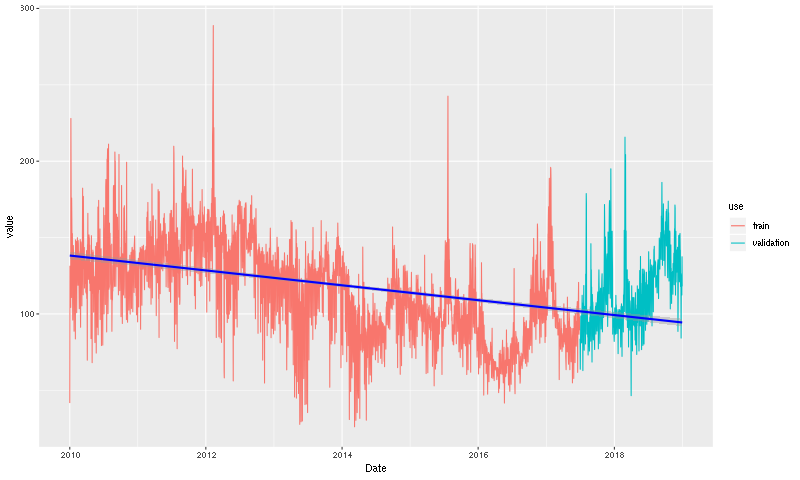

In [6]:
%%R -w 800

rbind(data.frame(Date=index(train), value=coredata(train), use="train"),
     data.frame(Date=index(validation), value=coredata(validation), use="validation")) %>%
    ggplot(aes(x=Date, y=value)) +
        geom_line(aes(colour = use)) +
        stat_smooth(method = "lm", se = T, col="blue", level=0.99)

# ARIMA with R

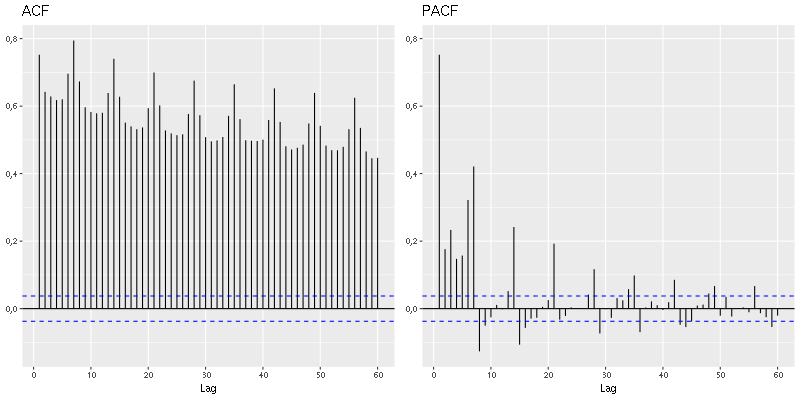

In [7]:
%%R -w 800 -h 400
## ------------------------------------------------------------------------
#This is the function ggtsdisplay of forecast package, 
#but it has been modified so is doesn't plot the series,
#just the ACF and PACF plot, with the horizontal parameter 
#the plot can be either horizontal or vertical
#The function has been simplified a lot, since we don't need 
#all the complexity the original one has.
ggtsdisplay_2 <- function(x, lag.max, horizontal=TRUE, ...) {
    if (!is.ts(x)) {
      x <- ts(x)
    }
    if (missing(lag.max)) {
      lag.max <- round(min(max(10 * log10(length(x)), 3 * frequency(x)), length(x) / 3))
    }
    ######      END   CHECKING    ########
    
    # Set up grid for plots
    if (horizontal){
      gridlayout <- matrix(c(2, 3), nrow = 1)
    }
    else{
      gridlayout <- matrix(c(2, 3), nrow = 2)
    }
    grid::grid.newpage()
    grid::pushViewport(grid::viewport(layout = grid::grid.layout(nrow(gridlayout), ncol(gridlayout))))
    
    # Prepare Acf plot
    acfplot <- do.call(ggAcf, c(x = quote(x), lag.max = lag.max)) +
      ggplot2::ggtitle("ACF") + ggplot2::ylab(NULL)

    # Prepare last plot (variable)
    pacfplot <- ggPacf(x, lag.max = lag.max) + ggplot2::ggtitle("PACF") +
      ggplot2::ylab(NULL)
    # Match y-axis
    acfplotrange <- ggplot2::layer_scales(acfplot)$y$range$range
    pacfplotrange <- ggplot2::layer_scales(pacfplot)$y$range$range
    yrange <- range(c(acfplotrange, pacfplotrange))
    acfplot <- acfplot + ggplot2::ylim(yrange)
    pacfplot <- pacfplot + ggplot2::ylim(yrange)

    # Add ACF plot
    matchidx <- as.data.frame(which(gridlayout == 2, arr.ind = TRUE))
    print(
      acfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )

    # Add PACF plot
    matchidx <- as.data.frame(which(gridlayout == 3, arr.ind = TRUE))
    print(
      pacfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )
  
}

ggtsdisplay_2(train, horizontal = TRUE, lag.max = 60)


Series: train 
ARIMA(0,0,0)(1,0,1)[7] with non-zero mean 
Box Cox transformation: lambda= 0,9742241 

Coefficients:
        sar1     sma1      mean
      0,9598  -0,5488  104,4242
s.e.  0,0065   0,0238    3,1736

sigma^2 estimated as 245:  log likelihood=-11419,73
AIC=22847,46   AICc=22847,48   BIC=22871,12


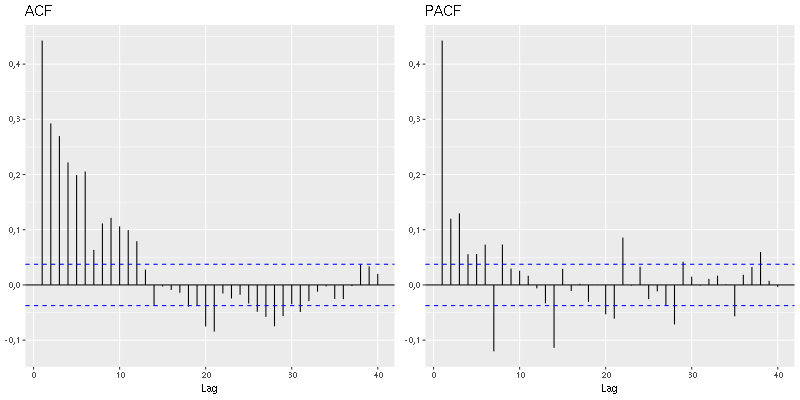

In [9]:
%%R -w 800 -h 400
mod1 <- Arima(train, c(0,0,0), list(order=c(1,0,1), period=7), lambda = "auto")
ggtsdisplay_2(mod1$residuals, lag.max = 40)
mod1

Vediamo anche che il coefficiente di SAR è molto vicino ad 1, quindi ha radice unitaria e ciò dice che esiste l'integrazione stagionale che sospettavamo prima. E il grafico del ACF e PACF mostrano ancora dei residui che sembrano un MA(6) (visti i primi 6 picchi di AR molto alti) e un AR(x) con x da trovare, ma allo stesso momento sembrano esserci delle anomalie per poter dire con sicurezza che sia un certo ARMA(x,6), forse c'è una compenente anche dell'integrazione non stagionale (perché la serie sembra avere un minimo di trend), quindi proviamo a vedere quale modello massimizza la log likelihood dove il modello sarà un ARMA$(p,q)$ con $p=0,...,6$ e $q=0,...,6$ insieme al SARIMA$(1,1,1)_7$ già trovato prima.

E' una sorta di GRID SEARCH sul modello ARIMA. Per il momento trascuriamo la parte dell'integrazione e ci pensiamo dopo aver trovato il modello ARMA migliore.

In [10]:
%%R
#checking the arributes an ARIMA object has, to find the log likelihood one.
attributes(mod1)

$names
 [1] "coef"      "sigma2"    "var.coef"  "mask"      "loglik"    "aic"      
 [7] "arma"      "residuals" "call"      "series"    "code"      "n.cond"   
[13] "nobs"      "model"     "aicc"      "bic"       "lambda"    "x"        
[19] "fitted"   

$class
[1] "forecast_ARIMA" "ARIMA"          "Arima"         



In [11]:
%%time
%%R

best_mod <- Arima(train, c(0,0,0), list(order=c(1,1,1), period=7), 
                  lambda = "auto")
best_loglik <- best_mod$loglik

for (i in 0:6){
    for (j in 0:6){
        tryCatch({
            temp_mod <- Arima(train, c(i,0,j), list(order=c(1,1,1), period=7), 
                          lambda = "auto")
            temp_mod_loglik <- temp_mod$loglik
            if (best_loglik < temp_mod$loglik){
                best_mod <- temp_mod
                best_loglik <- temp_mod$loglik
            } 
        }, error=function(e){temp_mod_loglik <- 99999})
        print(paste0("AR-",i," MA-",j,
                     " -- LOG_LIKE:",temp_mod_loglik, " --BEST:",best_loglik), 
              flush=TRUE)
    }
}

[1] "AR-0 MA-0 -- LOG_LIKE:-11375,7006117445 --BEST:-11375,7006117445"
[1] "AR-0 MA-1 -- LOG_LIKE:-11142,8592016978 --BEST:-11142,8592016978"
[1] "AR-0 MA-2 -- LOG_LIKE:-11092,8617455839 --BEST:-11092,8617455839"
[1] "AR-0 MA-3 -- LOG_LIKE:-11048,2675212404 --BEST:-11048,2675212404"
[1] "AR-0 MA-4 -- LOG_LIKE:-11022,3348619649 --BEST:-11022,3348619649"
[1] "AR-0 MA-5 -- LOG_LIKE:-11014,148578925 --BEST:-11014,148578925"
[1] "AR-0 MA-6 -- LOG_LIKE:-10940,4853263174 --BEST:-10940,4853263174"
[1] "AR-1 MA-0 -- LOG_LIKE:-11034,9166639061 --BEST:-10940,4853263174"
[1] "AR-1 MA-1 -- LOG_LIKE:-10929,9401611245 --BEST:-10929,9401611245"
[1] "AR-1 MA-2 -- LOG_LIKE:-10895,1826123982 --BEST:-10895,1826123982"
[1] "AR-1 MA-3 -- LOG_LIKE:-10895,1227201411 --BEST:-10895,1227201411"
[1] "AR-1 MA-4 -- LOG_LIKE:-10894,9476766266 --BEST:-10894,9476766266"
[1] "AR-1 MA-5 -- LOG_LIKE:-10894,9475953037 --BEST:-10894,9475953037"
[1] "AR-1 MA-6 -- LOG_LIKE:-10890,7799506615 --BEST:-10890,7799506615"
[1] "AR-

CPU times: user 7min 47s, sys: 21.3 s, total: 8min 8s
Wall time: 7min 38s


In [8]:
%%R

xts_to_ts <- function(x, start="2010-01-01"){
    n <- length(x)
    ind <- as.numeric(index(x) - as.Date(start))
    tsx <- ts(x, start=ind[1]+1, end=ind[n]+1, frequency=frequency(x))
    tsx
}

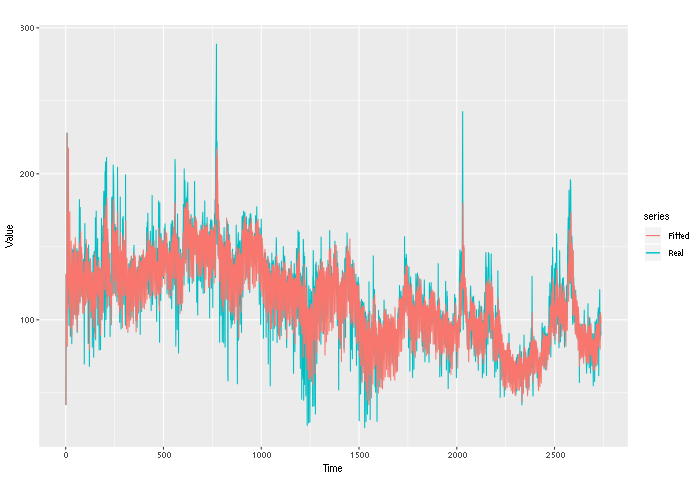

In [13]:
%%R -w 700

autoplot(xts_to_ts(train), series="Real")+
  autolayer(best_mod$fitted, series="Fitted")+
  ylab("Value")

In [14]:
%%R
best_mod #is ARMA(6,6)

Series: train 
ARIMA(6,0,6)(1,1,1)[7] 
Box Cox transformation: lambda= 0,9742241 

Coefficients:
         ar1     ar2     ar3     ar4      ar5      ar6      ma1      ma2
      0,6468  0,0744  0,2671  0,6543  -0,3382  -0,3129  -0,2548  -0,1173
s.e.  0,1784  0,1737  0,1365  0,1339   0,1673   0,1039   0,1759   0,1223
          ma3      ma4     ma5     ma6    sar1     sma1
      -0,2094  -0,7198  0,0419  0,3526  0,1313  -0,9697
s.e.   0,1007   0,0969  0,1504  0,0651  0,0291   0,0062

sigma^2 estimated as 168,9:  log likelihood=-10880,31
AIC=21790,63   AICc=21790,81   BIC=21879,31


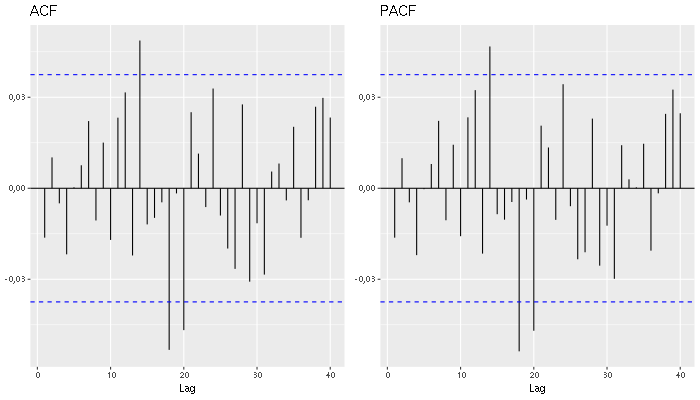

In [15]:
%%R -w 700 -h 400
ggtsdisplay_2(best_mod$residuals, lag.max = 40)

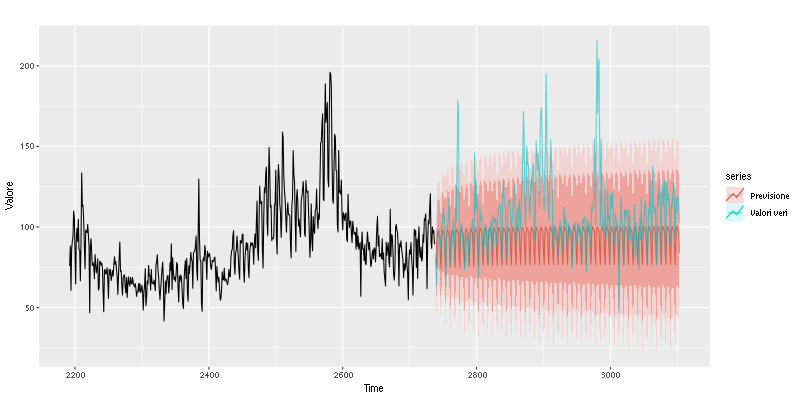

In [16]:
%%R -w 800 -h 400
pred <- forecast(best_mod, h=365)

autoplot(xts_to_ts(idata["2016-01-01/2017-06-30"])) +
  autolayer(pred,series="Previsione", alpha=0.7) +
  autolayer(xts_to_ts(validation["2017-07-01/2018-06-30"]), series="Valori veri", alpha=0.6) +
  xlab("Time") +
  ylab("Valore")

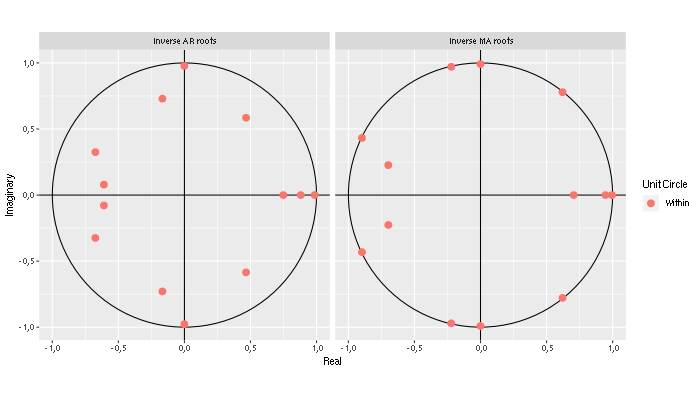

In [17]:
%%R -w 700 -h 400
autoplot(best_mod)

In [18]:
%%R
Mod(1/polyroot(c(1,-best_mod$coef[1:6])))

[1] 0,9773155 0,9858065 0,9773155 0,8808149 0,6142705 0,6142705


Modulo delle radici troppo vicino ad 1, significa che bisogna integrare (in effetti un po' di trend si vedeva sin dall'inizio). Iniziamo con integrazione del primo ordine, se non basta si proverà anche del secondo ordine.

Series: train 
ARIMA(6,1,6)(1,1,1)[7] 
Box Cox transformation: lambda= 0,9742241 

Coefficients:
          ar1      ar2      ar3      ar4     ar5     ar6     ma1      ma2
      -0,6830  -0,3886  -0,1617  -0,0121  0,1525  0,2552  0,0833  -0,2015
s.e.   0,1144   0,1518   0,1238   0,1305  0,0842  0,0431  0,1162   0,1122
          ma3      ma4      ma5      ma6    sar1     sma1
      -0,1894  -0,1758  -0,2276  -0,1139  0,2842  -0,9761
s.e.   0,1082   0,1425   0,0852   0,0953  0,0317   0,0052

sigma^2 estimated as 170,2:  log likelihood=-10889,81
AIC=21809,61   AICc=21809,79   BIC=21898,29


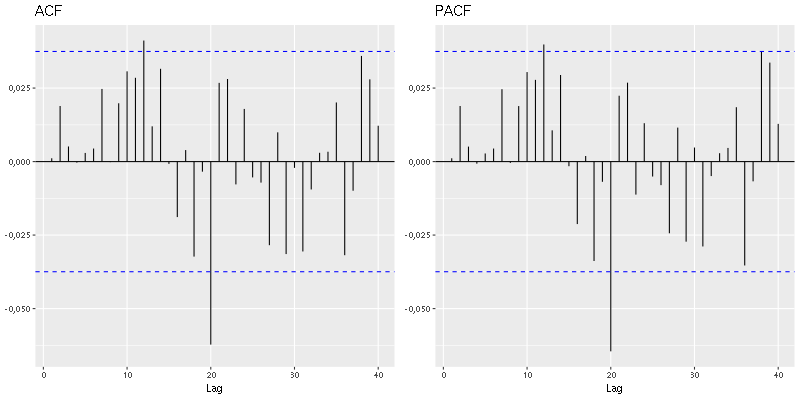

CPU times: user 34.9 s, sys: 605 ms, total: 35.5 s
Wall time: 34.6 s


In [19]:
%%time
%%R -w 800 -h 400
mod2 <- Arima(train, c(6,1,6), list(order=c(1,1,1), period=7), 
                          lambda = "auto")

ggtsdisplay_2(mod2$residuals, lag.max = 40)
mod2

I residui sembrano essere rientrati nella banda tranne un piccolo residuo a 20 sia un ACF che PACF.

[1] "Modulus of the AR roots:"
[1] 0,8184217 0,8267134 0,8267134 0,8184217 0,6894559 0,8085062


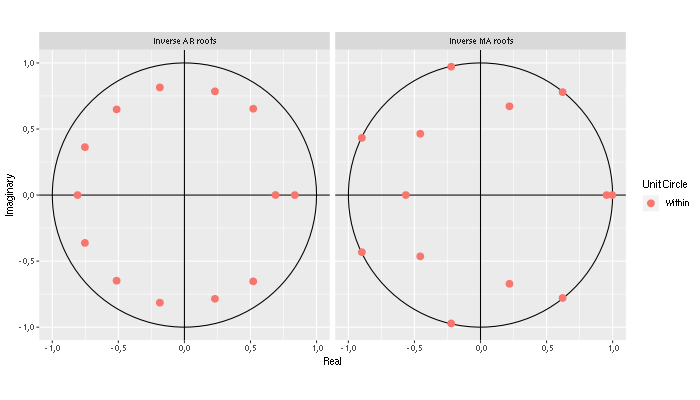

In [20]:
%%R -w 700 -h 400
#it shows the roots
print("Modulus of the AR roots:")
print(Mod(1/polyroot(c(1,-mod2$coef[1:6]))))
autoplot(mod2)

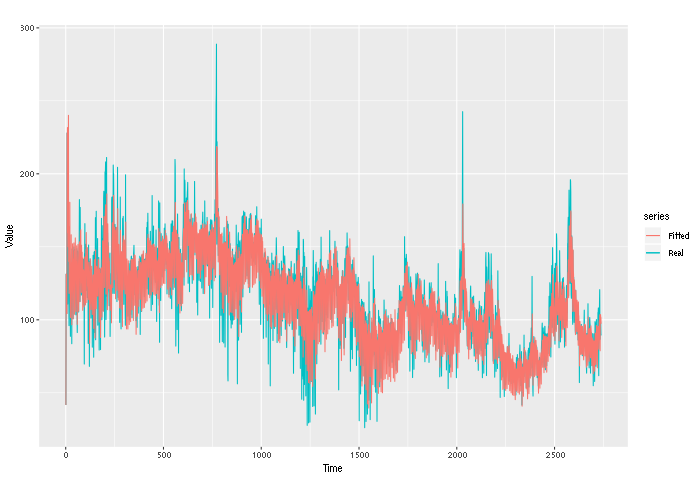

In [21]:
%%R -w 700

autoplot(xts_to_ts(train), series="Real")+
  autolayer(mod2$fitted, series="Fitted")+
  ylab("Value")

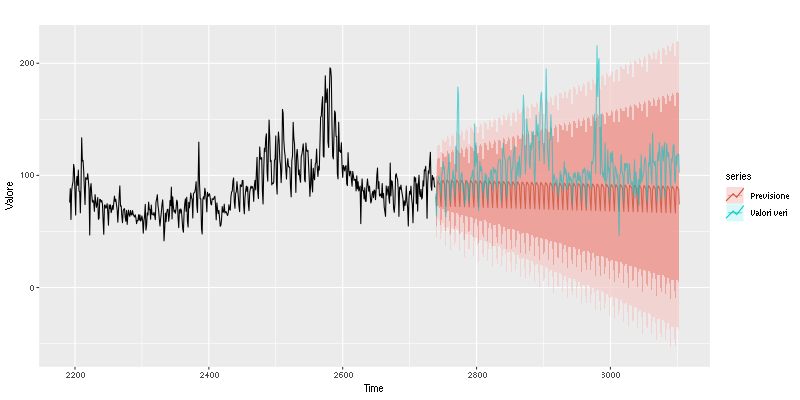

In [22]:
%%R -w 800 -h 400
pred <- forecast(mod2, h=365)

autoplot(xts_to_ts(idata["2016-01-01/2017-06-30"])) +
  autolayer(pred,series="Previsione", alpha=0.7) +
  autolayer(xts_to_ts(validation["2017-07-01/2018-06-30"]), series="Valori veri", alpha=0.6) +
  xlab("Time") +
  ylab("Valore")

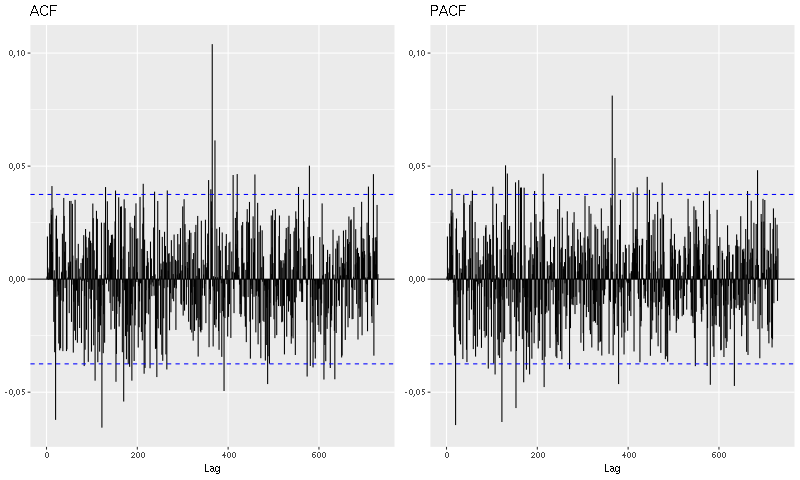

In [23]:
%%R -w 800
ggtsdisplay_2(mod2$residuals, lag.max = 365*2)

Questa serie presenta in realtà una multi-stagionalità come si può vedere nel ACF e PACF sopra, che non può essere risolta con R, per questo si prova ad usare regressori esterni, introducendo una stagionalità annuale e ogni 4 settimane quindi mettiamo regressori dummy mensili e ogni 4 settimane.

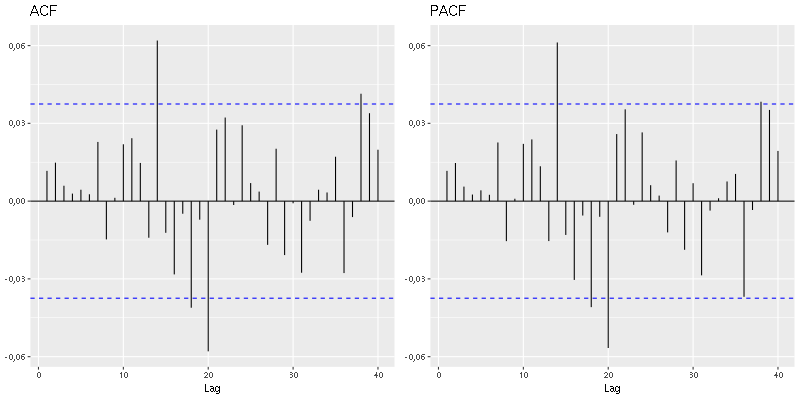

CPU times: user 21min 9s, sys: 35min 52s, total: 57min 1s
Wall time: 7min 24s


In [22]:
%%time
%%R -w 800 -h 400
#create dummy

freq <- outer(1:nrow(df), 1:24)*2*pi/365.25 

cs   <- cos(freq)                   
colnames(cs) <- paste("cos", 1:24)
si   <- sin(freq)                   
colnames(si) <- paste("cos", 1:24)

more_reg <- as.matrix(cbind(cs,si))

xreg <- more_reg 

mod1_reg <- Arima(train, c(6,1,6), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:(length(train)),], include.constant = TRUE, lambda = "auto")

ggtsdisplay_2(mod1_reg$residuals, lag.max = 40)

In [23]:
%%R
print(paste0("MAPE on train ", mean(abs(mod1_reg$fitted-as.numeric(train))/as.numeric(train)))) #train_perf

[1] "MAPE on train 0,0949685786830177"


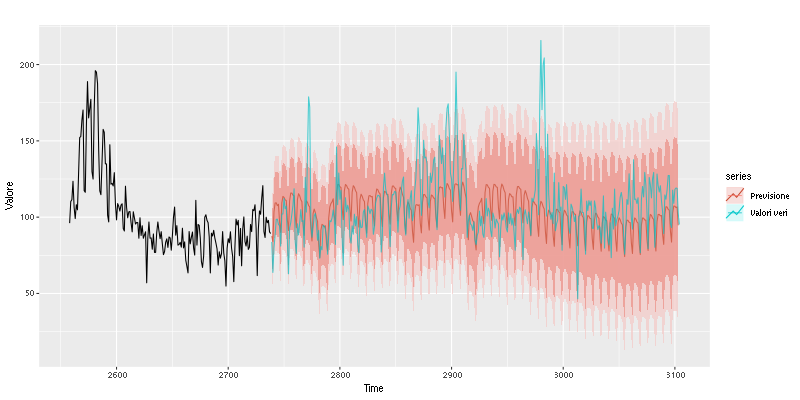

In [24]:
%%R -w 800 -h 400
pred_reg <- forecast(mod1_reg, h=334, 
              xreg=xreg[(length(train)+1):(length(train)+365),])
autoplot(pred_reg)

autoplot(xts_to_ts(train["2017-01-01/2017-06-30"])) +
    autolayer(pred_reg,series="Previsione",alpha=0.7) +
    autolayer(xts_to_ts(validation["2017-07-01/2018-07-01"]), series="Valori veri", alpha=0.7)+
    ylab("Valore")

In [39]:
%%time
%%R

#i=0
temp_forecast <- forecast(mod1_reg, h=334, xreg=xreg[(length(train)):(length(train)+333),])
score <- c(mean(abs(temp_forecast$mean - validation[1:334])/validation[1:334]))

for (i in 1:(length(validation) - 334)){
    temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
    temp_forecast <- forecast(temp_mod, h=334, xreg=xreg[(length(train)+i+1):(length(train)+i+334),])$mean
    score <- c(score, mean(abs(temp_forecast - validation[(i+1):(i+334)])/validation[(i+1):(i+334)]))
}

print(paste0("ARIMA average MAPE:", mean(score)))
arima_score <- mean(score)

[1] "ARIMA average MAPE:0,145042642929595"


CPU times: user 1min 10s, sys: 2min 46s, total: 3min 56s
Wall time: 32.3 s



	Ljung-Box test

data:  Residuals from Regression with ARIMA(6,1,6)(1,1,1)[7] errors
Q* = 85,356, df = 3, p-value < 2,2e-16

Model df: 62.   Total lags used: 65



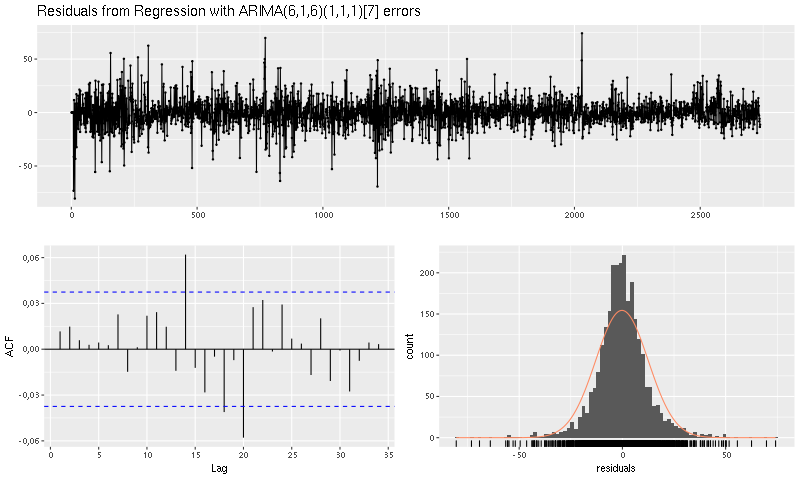

In [49]:
%%R -w 800
checkresiduals(mod1_reg)

adding vacations

In [9]:
%%R
listHolidays()

  [1] "Advent1st"                "Advent2nd"               
  [3] "Advent3rd"                "Advent4th"               
  [5] "AllSaints"                "AllSouls"                
  [7] "Annunciation"             "Ascension"               
  [9] "AshWednesday"             "AssumptionOfMary"        
 [11] "BirthOfVirginMary"        "BoxingDay"               
 [13] "CACanadaDay"              "CACivicProvincialHoliday"
 [15] "CALabourDay"              "CaRemembranceDay"        
 [17] "CAThanksgivingDay"        "CAVictoriaDay"           
 [19] "CelebrationOfHolyCross"   "CHAscension"             
 [21] "CHBerchtoldsDay"          "CHConfederationDay"      
 [23] "CHKnabenschiessen"        "ChristmasDay"            
 [25] "ChristmasEve"             "ChristTheKing"           
 [27] "CHSechselaeuten"          "CorpusChristi"           
 [29] "DEAscension"              "DEChristmasEve"          
 [31] "DECorpusChristi"          "DEGermanUnity"           
 [33] "DENewYearsEve"            "Easter

In [16]:
%%R

#festività natalizie
capodanno <- as.Date(c(unlist(lapply(2010:2019, 
                    function(a) lapply(c("-01-01","-12-31"), 
                                              function (b) paste0(a, b))))))
natale <- as.Date(c(unlist(lapply(2010:2019, 
                    function(a) lapply(paste0("-12-",c(24:26)), 
                                              function (b) paste0(a, b))))))

#Ferragosto
ferragosto <- as.Date(paste0(2010:2019, "-08-15"))

#Pasqua festività
pasqua <- as.Date(c(Easter(2010:2018), EasterMonday(2010:2018)))

#Altre Festività (quasi tutte le più importanti)
altre <- c(as.Date(c(LaborDay(2010:2018), ITAllSaints(2010:2018), 
                   ITLiberationDay(2010:2018), ITImmaculateConception(2010:2018))),
                   as.Date(paste0(2010:2018,"-06-02")), #Festa della Repubblica
                   as.Date(paste0(2010:2018,"-01-06")), #Befana
                   as.Date(c("2010-02-16", "2011-03-08", #carnevale
                            "2012-02-21", "2013-02-12",
                            "2014-03-04", "2015-02-17",
                            "2016-02-09", "2017-02-28",
                            "2018-02-13", "2019-03-05"))) 

In [17]:
%%R
altre

 [1] "2010-05-01" "2011-05-01" "2012-05-01" "2013-05-01" "2014-05-01"
 [6] "2015-05-01" "2016-05-01" "2017-05-01" "2018-05-01" "2010-11-01"
[11] "2011-11-01" "2012-11-01" "2013-11-01" "2014-11-01" "2015-11-01"
[16] "2016-11-01" "2017-11-01" "2018-11-01" "2010-04-25" "2011-04-25"
[21] "2012-04-25" "2013-04-25" "2014-04-25" "2015-04-25" "2016-04-25"
[26] "2017-04-25" "2018-04-25" "2010-12-08" "2011-12-08" "2012-12-08"
[31] "2013-12-08" "2014-12-08" "2015-12-08" "2016-12-08" "2017-12-08"
[36] "2018-12-08" "2010-06-02" "2011-06-02" "2012-06-02" "2013-06-02"
[41] "2014-06-02" "2015-06-02" "2016-06-02" "2017-06-02" "2018-06-02"
[46] "2010-01-06" "2011-01-06" "2012-01-06" "2013-01-06" "2014-01-06"
[51] "2015-01-06" "2016-01-06" "2017-01-06" "2018-01-06" "2010-02-16"
[56] "2011-03-08" "2012-02-21" "2013-02-12" "2014-03-04" "2015-02-17"
[61] "2016-02-09" "2017-02-28" "2018-02-13" "2019-03-05"


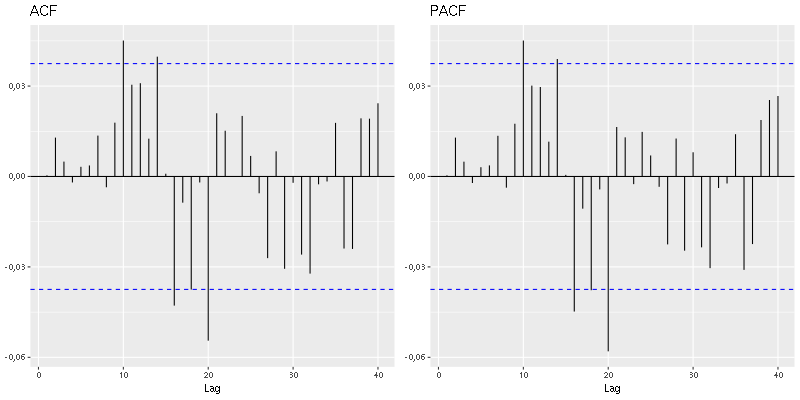

CPU times: user 24min 10s, sys: 41min 23s, total: 1h 5min 34s
Wall time: 8min 34s


In [40]:
%%time
%%R -w 800 -h 400
#create dummy

freq <- outer(1:nrow(df), 1:24)*2*pi/365.25 

cs   <- cos(freq)                   
colnames(cs) <- paste("cos", 1:24)
si   <- sin(freq)                   
colnames(si) <- paste("cos", 1:24)

more_reg <- as.matrix(cbind(cs,si))

data.frame(Data=df$Data) %>%
    mutate(Christmas = as.numeric(Data %in% natale)) %>%
    mutate(NewYear = as.numeric(Data %in% capodanno)) %>%
    mutate(Easter = as.numeric(Data %in% pasqua)) %>%
    mutate(Ferragosto = as.numeric(Data %in% ferragosto)) %>%
    mutate(Other = as.numeric(Data %in% altre)) %>%
    select(-starts_with("Data")) %>% 
    cbind(more_reg) %>% 
    as.matrix() -> more_reg

xreg <- more_reg 

mod2_reg <- Arima(train, c(6,1,6), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:(length(train)),], include.constant = TRUE, lambda = "auto")

ggtsdisplay_2(mod2_reg$residuals, lag.max = 40)

In [41]:
%%time
%%R

#i=0
temp_forecast <- forecast(mod2_reg, h=334, xreg=xreg[(length(train)):(length(train)+333),])
score <- c(mean(abs(temp_forecast$mean - validation[1:334])/validation[1:334]))

for (i in 1:(length(validation) - 334)){
    temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod2_reg, xreg=xreg[i:(length(train)+i),])
    temp_forecast <- forecast(temp_mod, h=334, xreg=xreg[(length(train)+i+1):(length(train)+i+334),])$mean
    score <- c(score, mean(abs(temp_forecast - validation[(i+1):(i+334)])/validation[(i+1):(i+334)]))
}

print(paste0("ARIMA average MAPE:", mean(score)))
arima_score <- mean(score)

[1] "ARIMA average MAPE:0,180301369662147"


CPU times: user 1min 13s, sys: 2min 52s, total: 4min 6s
Wall time: 34 s


Best one is without vacations

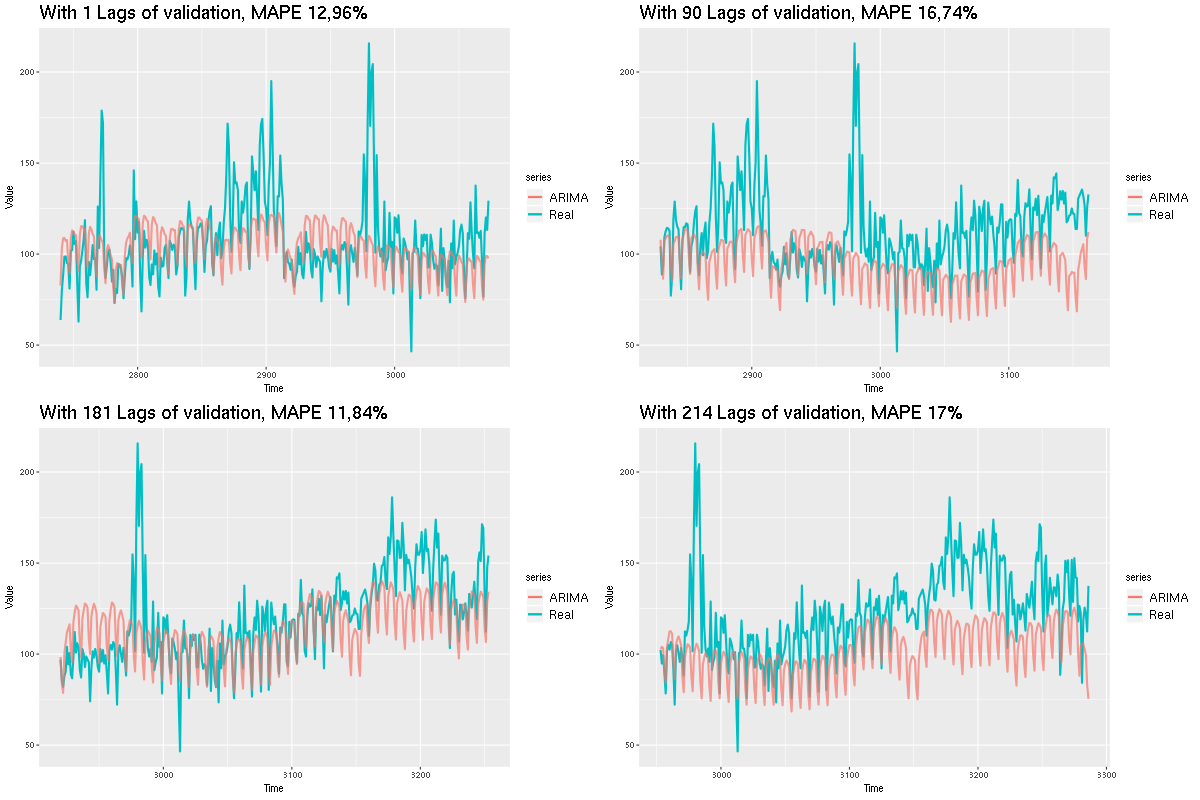

In [44]:
%%R -w 1200 -h 800
i=1
temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=334, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+334),])$mean
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p1 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))
        
i=90

temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=334, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+334),])$mean
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p2 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))

i=181

temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=334, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+334),])$mean
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p3 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))
        
i=214
temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=334, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+334),])$mean
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p4 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))

gridExtra::grid.arrange(p1, p2, p3, p4, nrow = 2)

# UCM with R

## LLT + regressor 

In [45]:
%%time
%%R

ytrain <- as.numeric(train)
#ytrain[(length(ytrain)+1):(length(ytrain)+365)] <- NA
#ytrain <- xts(ytrain, order.by=df$Data)

data.frame(Data=df$Data) %>%
    mutate(Christmas = as.numeric(as.numeric(Data %in% natale))) %>%
    mutate(Ferragosto = as.numeric(as.numeric(Data %in% ferragosto))) %>%
    mutate(Easter = as.numeric(as.numeric(Data %in% pasqua))) %>%
    mutate(Other = as.numeric(Data %in% altre)) %>%
    select(-starts_with("Data"))  -> more_reg

#Si comporta peggio se si usano i regressori con i quali XARIMA funzionava meglio!?
ucm_mod1 <- SSModel(ytrain ~  Christmas + Ferragosto + Easter +
                      Other +
                      SSMtrend(2, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                H = NA, data=more_reg[1:length(ytrain),])

vary <- var(ytrain, na.rm = TRUE)
ucm_mod1$P1inf <- ucm_mod1$P1inf * 0
ucm_mod1$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod1$P1) <- vary



# valori iniziali delle varianze
init <- numeric(5)
init[1] <- log(vary/10) 
init[2] <- log(vary/10)
init[3] <- log(vary/100)
init[4] <- log(vary/100)
init[5] <- log(vary/10)

# funzione di aggiornamento
update_fun <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[4:51, 4:51, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit1 <- fitSSM(ucm_mod1, init, update_fun)
print(fit1$optim.out$convergence)

[1] 0


CPU times: user 1min 44s, sys: 2min 17s, total: 4min 1s
Wall time: 34.6 s


In [46]:
%%time
%%R

### i=0
data <- c(rep(NA, 334))
temp_mod <- SSModel(data ~  Christmas + Ferragosto + Easter +
                      Other +
                      SSMtrend(2, list(fit1$model$Q[1,1,1],fit1$model$Q[2,2,1])) +
                      SSMseasonal(7, fit1$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit1$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                    H = fit1$model$H, 
                    data=more_reg[(length(train)+1):(length(train)+334),])
ucm_pred <- predict(fit1$model, newdata=temp_mod)[1:334]
valid <- as.numeric(validation)[1:334]

score <- c(mean(abs(ucm_pred - valid)/valid))

for (i in 1:(length(validation) - 334)){
    data <- c(as.numeric(validation[1:i]), rep(NA, 334))
    temp_mod <- SSModel(data ~  Christmas + Ferragosto + Easter +
                      Other +
                      SSMtrend(2, list(fit1$model$Q[1,1,1],fit1$model$Q[2,2,1])) +
                      SSMseasonal(7, fit1$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit1$model$Q[4, 4, 1], "trig",
                                  harmonics = 1:24),
                    H = fit1$model$H, 
                        data=more_reg[(length(train)+1):(length(train)+i+334),])
    #ucm_pred <- predict(fit1$model, newdata=temp_mod, n.ahead=365)[i:(i+334)]
    ucm_pred <- predict(fit1$model, newdata=temp_mod, n.ahead=334)[(i+1):(i+334)]
    valid <- as.numeric(validation)[(i+1):(i+334)]
    score <- c(score, mean(abs(ucm_pred - valid)/valid))
}
print(mean(score))

[1] 0,2199865


CPU times: user 8min 22s, sys: 9min 42s, total: 18min 5s
Wall time: 3min 48s


## only LLT 

In [34]:
%%time
%%R
ucm_mod2 <- SSModel(ytrain ~ SSMtrend(2, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                H = NA)

vary <- var(ytrain, na.rm = TRUE)
ucm_mod2$P1inf <- ucm_mod2$P1inf * 0
ucm_mod2$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod2$P1) <- vary



#valori iniziali delle varianze
init <- numeric(5)
init[1] <- log(vary/10) 
init[2] <- log(vary/10) 
init[3] <- log(vary/100)
init[4] <- log(vary/100)
init[5] <- log(vary/10) 

#funzione per fitSSM
update_fun <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[4:51, 4:51, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit2 <- fitSSM(ucm_mod2, init, update_fun)
print(fit2$optim.out$convergence)

[1] 0


CPU times: user 1min 46s, sys: 2min 13s, total: 3min 59s
Wall time: 34.3 s


In [35]:
%%time
%%R

data <- c(rep(NA, 334))
temp_mod <- SSModel(data ~  SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                      SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                    H = fit2$model$H)
ucm_pred <- predict(fit2$model, newdata=temp_mod)[1:334]
valid <- as.numeric(validation)[1:334]

score <- c(mean(abs(ucm_pred - valid)/valid))

for (i in 1:(length(validation) - 334)){
    data <- c(as.numeric(validation[1:i]), rep(NA, 334))
    temp_mod <- SSModel(data ~ SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                      SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                                  harmonics = 1:24),
                    H = fit2$model$H)
    ucm_pred <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+334)]
    valid <- as.numeric(validation)[(i+1):(i+334)]
    score <- c(score,mean(abs(ucm_pred - valid)/valid))
}
print(paste0("UCM average MAPE:", mean(score)))
ucm_score <- mean(score)

[1] "UCM average MAPE:0,189428326970963"


CPU times: user 7min 26s, sys: 8min 29s, total: 15min 55s
Wall time: 3min 11s


## RW

In [10]:
%%time
%%R

ytrain <- as.numeric(train)

ucm_mod3 <- SSModel(ytrain ~ SSMtrend(1, NA) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                H = NA)

vary <- var(ytrain, na.rm = TRUE)
ucm_mod3$P1inf <- ucm_mod3$P1inf * 0
ucm_mod3$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod3$P1) <- vary



#valori iniziali delle varianze
init <- numeric(5)
init[1] <- log(vary/10) 
init[2] <- log(vary/100)
init[3] <- log(vary/100)
init[4] <- log(vary/10) 

#funzione per fitSSM
update_fun <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    diag(model$Q[3:50, 3:50, 1]) <- exp(pars[3])
    model$H[1, 1, 1] <- exp(pars[4])
    model
}

fit3 <- fitSSM(ucm_mod3, init, update_fun)
print(fit3$optim.out$convergence)

[1] 0


CPU times: user 3min 5s, sys: 4min 50s, total: 7min 56s
Wall time: 1min 1s


In [15]:
%%time
%%R

data <- c(rep(NA, 334))
temp_mod <- SSModel(data ~  SSMtrend(1, fit3$model$Q[1,1,1]) +
                      SSMseasonal(7, fit3$model$Q[2,2,1], "dummy") +
                      SSMseasonal(365, fit3$model$Q[3, 3, 1], "trig",
                              harmonics = 1:24),
                    H = fit3$model$H)
ucm_pred <- predict(fit3$model, newdata=temp_mod)[1:334]
valid <- as.numeric(validation)[1:334]

score <- c(mean(abs(ucm_pred - valid)/valid))

for (i in 1:(length(validation) - 334)){
    data <- c(as.numeric(validation[1:i]), rep(NA, 334))
    temp_mod <- SSModel(data ~  SSMtrend(1, fit3$model$Q[1,1,1]) +
                          SSMseasonal(7, fit3$model$Q[2,2,1], "dummy") +
                          SSMseasonal(365, fit3$model$Q[3, 3, 1], "trig",
                              harmonics = 1:24),
                        H = fit3$model$H)
    ucm_pred <- predict(fit3$model, newdata=temp_mod)[(i+1):(i+334)]
    valid <- as.numeric(validation)[(i+1):(i+334)]
    score <- c(score,mean(abs(ucm_pred - valid)/valid))
}
print(paste0("UCM average MAPE:", mean(score)))
ucm_score <- mean(score)

[1] "UCM average MAPE:0,180903527818786"


CPU times: user 8min 44s, sys: 11min 27s, total: 20min 11s
Wall time: 3min 42s


# IRW

In [21]:
%%time
%%R
ucm_mod2 <- SSModel(ytrain ~ SSMtrend(2, list(0,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                H = NA)

vary <- var(ytrain, na.rm = TRUE)
ucm_mod2$P1inf <- ucm_mod2$P1inf * 0
ucm_mod2$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod2$P1) <- vary



#valori iniziali delle varianze
init <- numeric(5)
init[1] <- 0
init[2] <- log(vary/10) 
init[3] <- log(vary/100)
init[4] <- log(vary/100)
init[5] <- log(vary/10) 

#funzione per fitSSM
update_fun <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[4:51, 4:51, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit2 <- fitSSM(ucm_mod2, init, update_fun)
print(fit2$optim.out$convergence)

[1] 0


CPU times: user 2min 26s, sys: 3min 24s, total: 5min 50s
Wall time: 51.9 s


In [22]:
%%time
%%R

data <- c(rep(NA, 334))
temp_mod <- SSModel(data ~  SSMtrend(2, list(0,fit2$model$Q[2,2,1])) +
                      SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                    H = fit2$model$H)
ucm_pred <- predict(fit2$model, newdata=temp_mod)[1:334]
valid <- as.numeric(validation)[1:334]

score <- c(mean(abs(ucm_pred - valid)/valid))

for (i in 1:(length(validation) - 334)){
    data <- c(as.numeric(validation[1:i]), rep(NA, 334))
    temp_mod <- SSModel(data ~ SSMtrend(2, list(0,fit2$model$Q[2,2,1])) +
                      SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                                  harmonics = 1:24),
                    H = fit2$model$H)
    ucm_pred <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+334)]
    valid <- as.numeric(validation)[(i+1):(i+334)]
    score <- c(score,mean(abs(ucm_pred - valid)/valid))
}
print(paste0("UCM average MAPE:", mean(score)))
ucm_score <- mean(score)

[1] "UCM average MAPE:0,167597255610672"


CPU times: user 9min 1s, sys: 9min 31s, total: 18min 33s
Wall time: 4min 38s


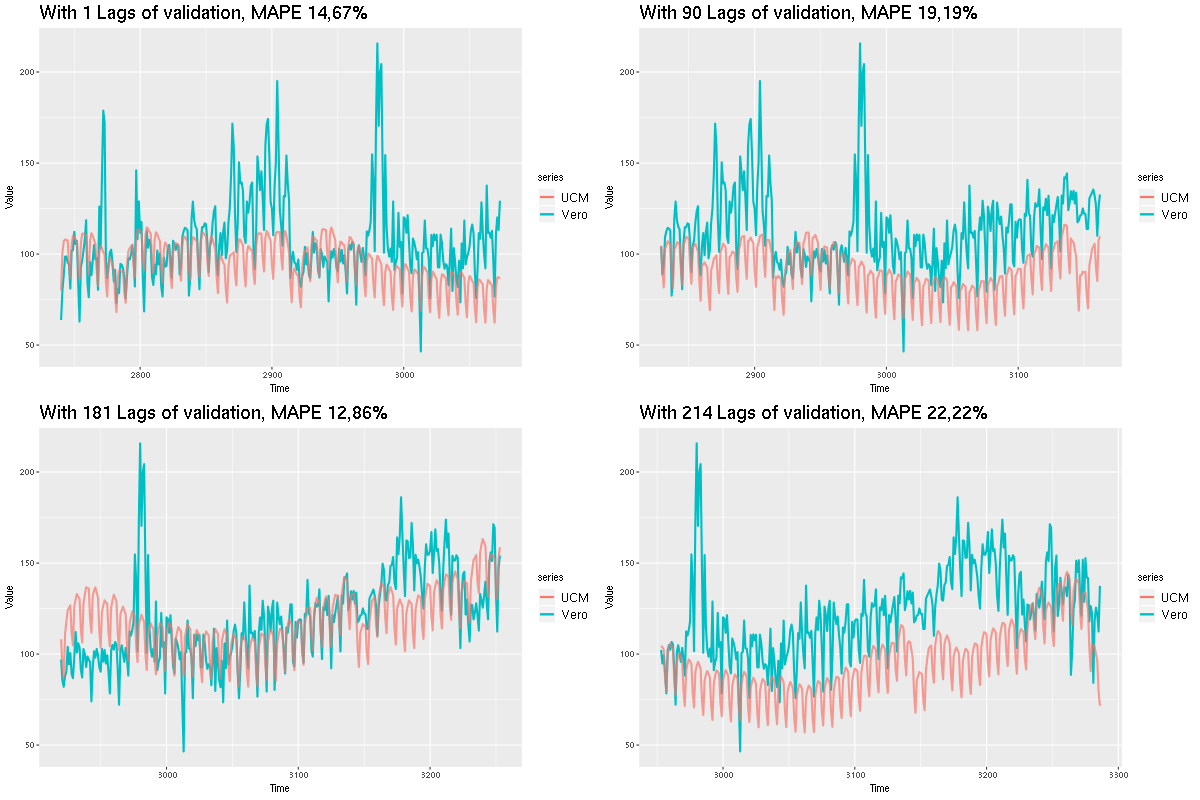

In [23]:
%%R -w 1200 -h 800
i=1
data <- c(as.numeric(validation[1:i]), rep(NA, 334))
temp_mod <- SSModel(data ~ SSMtrend(2, list(0,fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+334)]
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p1 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Vero",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))

        
i=90

data <- c(as.numeric(validation[1:i]), rep(NA, 334))
temp_mod <- SSModel(data ~ SSMtrend(2, list(0,fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+334)]
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p2 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Vero",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))

i=181

data <- c(as.numeric(validation[1:i]), rep(NA, 334))
temp_mod <- SSModel(data ~ SSMtrend(2, list(0,fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+334)]
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p3 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Vero",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))
        
i=214
data <- c(as.numeric(validation[1:i]), rep(NA, 334))
temp_mod <- SSModel(data ~ SSMtrend(2, list(0,fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+334)]
valid <- validation[(i+1):(i+334)]
mae <- mean(abs(temp_forecast - valid)/valid)

p4 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Vero",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + 
        ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%")) +
        theme(plot.title=element_text(size=18),
             legend.text=element_text(size=12))

gridExtra::grid.arrange(p1, p2, p3, p4, nrow = 2)

[1] "MAPE on train 0,109807495987043"


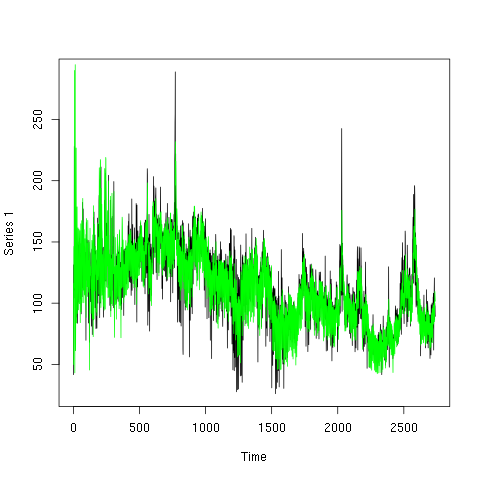

In [24]:
%%R
#in training:

smo1 <- KFS(fit2$model, filtering = "mean", smoothing = NULL)

plot(xts_to_ts(train))
lines(smo1$m, col="green")
print(paste0("MAPE on train ",mean(abs(xts_to_ts(train) - smo1$m)/xts_to_ts(train))))

# LSTM with Python

In [38]:
%%capture
!pip install parameter-sherpa

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import time

%matplotlib inline

In [36]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import sherpa #AutoML

from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("Tesorflow Version:", tf.__version__)
print("Keras Version:",tf.keras.__version__)

Tesorflow Version: 2.0.0
Keras Version: 2.2.4-tf


In [37]:
path = "data/"
#path = "/content/drive/My Drive/ts_proj/"

In [38]:
df = pd.read_csv(path + "time_series_dataset.csv", sep=";", decimal=".")
df.Data = pd.to_datetime(df.Data)
df.head()

,Data,value
0,2010-01-01,41.651044
1,2010-01-02,131.286604
2,2010-01-03,117.388117
3,2010-01-04,116.461280
4,2010-01-05,123.823765


In [39]:
train = df[df.Data <= pd.to_datetime("2017-06-30")]
val  = df[df.Data  > pd.to_datetime("2017-06-30")]

x_scaler = StandardScaler().\
            fit(np.array(train.value).reshape(-1,1))

train_scaled = x_scaler.transform(np.array(train.value).reshape(-1,1))
val_scaled = x_scaler.transform(np.array(val.value).reshape(-1,1))

data_scaled = np.concatenate((train_scaled, val_scaled))

In [40]:
def sliding_windows(data, seq_length, pred_lenght):
    x = []
    y = []

    for i in range(len(data)-seq_length-pred_lenght-1):
        x.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length:i+seq_length+pred_lenght])

    return np.array(x),np.array(y)

In [41]:
INPUT_SIZE = 365*2 #2 years
OUTPUT_SIZE = 334


slides = sliding_windows(data_scaled, 
                         INPUT_SIZE ,OUTPUT_SIZE)

X = slides[0].reshape(slides[0].shape[0],
                            slides[0].shape[1],
                           1)
y = slides[1]

X_train, X_val = X[:-216], X[-216:]
y_train, y_val = y[:-216].reshape(-1,y.shape[1]), y[-216:].reshape(-1,y.shape[1])

In [42]:
print(X_train.shape)
print(X_val.shape)

(2006, 730, 1)
(216, 730, 1)


In [43]:
print(y_train.shape)
print(y_val.shape)

(2006, 334)
(216, 334)


### First Architecture

In [0]:
#The number of epoch could also be an hyperparameter
# but to reduce the computation stress it has been 
# fixed to be 100, (on approximately 2000 data) it is sufficient,
# otherwise it will start overfitting a lot! 
def get_model_score(params, epochs=100, verbose=0):
    early = EarlyStopping(monitor='val_loss', patience=50, verbose=0)
    lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=0, 
                             factor=0.5, min_lr=1e-5)
    initial = Input(shape=(INPUT_SIZE,1))

    x = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)

    x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit2"]), activation='relu')(x)

    out = Dense(OUTPUT_SIZE, activation='linear')(x)

    model = Model(initial, out)

    model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[lr_decay, early],
            verbose=verbose)
    return model, model.evaluate(X_val, y_val)[0], hist

In [0]:
parameters = [sherpa.Discrete('lstm_unit',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Continuous('lr_init', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [14]:
best_score = 999999

for trial in study:
    start_time = time.time()
    
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
        score = 999999
        print("Model Crashed or 'NaNed'")
      
    if score != 999999:
        study.add_observation(trial, iteration=1, objective=score)
        if score < best_score:
            model.save(path + "best_model.h5")
            best_model   = model
            best_score   = score
            best_history = hist
    else:
        del model #free RAM
    study.finalize(trial)
    if(trial.id % 10 == 0 or trial.id == 1):
        print("Trial:",trial.id, "|| Best Score: ", best_score, " || Took ",str(time.time()-start_time), "Seconds")
    study.results.to_csv(path + "AutoML.csv")

216/216 [==============================] - 0s 569us/sample - loss: 0.8090 - mae: 0.6730
Trial: 1 || Best Score:  0.8090038741076434  || Took  77.10110139846802 Seconds


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


216/216 [==============================] - 0s 367us/sample - loss: 0.9261 - mae: 0.7178


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 597us/sample - loss: 0.8517 - mae: 0.7037


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 496us/sample - loss: 0.9464 - mae: 0.7240


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 550us/sample - loss: 0.9503 - mae: 0.7181


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 563us/sample - loss: 0.8307 - mae: 0.6969


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 10 || Best Score:  0.7883809937371148  || Took  117.44060444831848 Seconds
216/216 [==============================] - 0s 585us/sample - loss: 0.8503 - mae: 0.7090


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 598us/sample - loss: 0.8180 - mae: 0.6893


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 582us/sample - loss: 0.8785 - mae: 0.7068


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 513us/sample - loss: 0.7376 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 517us/sample - loss: 0.9230 - mae: 0.7110


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 582us/sample - loss: 0.9024 - mae: 0.7092


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 510us/sample - loss: 0.8214 - mae: 0.6772


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 515us/sample - loss: 0.8654 - mae: 0.7073


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 525us/sample - loss: 0.8674 - mae: 0.6912


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 503us/sample - loss: 0.8764 - mae: 0.6998


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 20 || Best Score:  0.7375906816235295  || Took  64.60448241233826 Seconds
216/216 [==============================] - 0s 585us/sample - loss: 0.6847 - mae: 0.6145


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 569us/sample - loss: 0.6742 - mae: 0.6162


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 556us/sample - loss: 0.8260 - mae: 0.6995


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 586us/sample - loss: 0.7927 - mae: 0.6850


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 613us/sample - loss: 0.8802 - mae: 0.7106


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 488us/sample - loss: 0.8867 - mae: 0.7122


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 544us/sample - loss: 0.8884 - mae: 0.7109


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 461us/sample - loss: 0.8440 - mae: 0.6979


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 551us/sample - loss: 0.7592 - mae: 0.6657


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 588us/sample - loss: 0.8536 - mae: 0.7068


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 30 || Best Score:  0.6742125352223715  || Took  105.92102098464966 Seconds
216/216 [==============================] - 0s 581us/sample - loss: 0.6450 - mae: 0.6016


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 610us/sample - loss: 0.8593 - mae: 0.6842


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 560us/sample - loss: 0.8580 - mae: 0.7050


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 596us/sample - loss: 0.6344 - mae: 0.5978


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 582us/sample - loss: 0.8276 - mae: 0.6999


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 559us/sample - loss: 0.7968 - mae: 0.6966


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 567us/sample - loss: 0.8286 - mae: 0.6955


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 551us/sample - loss: 0.8989 - mae: 0.7092


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 591us/sample - loss: 0.9244 - mae: 0.7105


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 542us/sample - loss: 0.8687 - mae: 0.7006


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 40 || Best Score:  0.6343820249592816  || Took  95.13495540618896 Seconds
216/216 [==============================] - 0s 376us/sample - loss: 0.9322 - mae: 0.7212


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 408us/sample - loss: 0.9195 - mae: 0.7131


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 420us/sample - loss: 0.9131 - mae: 0.7101


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 416us/sample - loss: 0.9540 - mae: 0.7329


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 456us/sample - loss: 0.9372 - mae: 0.7209


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 575us/sample - loss: 0.8555 - mae: 0.7026


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 495us/sample - loss: 0.9637 - mae: 0.7451


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 580us/sample - loss: 0.8355 - mae: 0.6751


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 519us/sample - loss: 0.9249 - mae: 0.7139


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 513us/sample - loss: 0.9273 - mae: 0.7296


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 50 || Best Score:  0.6343820249592816  || Took  55.53041481971741 Seconds
216/216 [==============================] - 0s 572us/sample - loss: 0.8309 - mae: 0.6955


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 575us/sample - loss: 0.8273 - mae: 0.6668


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 559us/sample - loss: 0.8577 - mae: 0.7060


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 501us/sample - loss: 0.8861 - mae: 0.7045


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 491us/sample - loss: 0.9630 - mae: 0.7349


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 567us/sample - loss: 0.9396 - mae: 0.7144


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 372us/sample - loss: 0.9033 - mae: 0.7234


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 382us/sample - loss: 0.8841 - mae: 0.6951


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 388us/sample - loss: 0.9683 - mae: 0.7414


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 474us/sample - loss: 0.8960 - mae: 0.7184


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 60 || Best Score:  0.6343820249592816  || Took  51.99523687362671 Seconds
216/216 [==============================] - 0s 452us/sample - loss: 0.9593 - mae: 0.7304


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 391us/sample - loss: 0.8773 - mae: 0.6930


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 433us/sample - loss: 0.8581 - mae: 0.6953


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 486us/sample - loss: 0.9147 - mae: 0.7252


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 689us/sample - loss: 1.0002 - mae: 0.7335


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 603us/sample - loss: 0.9312 - mae: 0.7204


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 657us/sample - loss: 0.9330 - mae: 0.7159


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 425us/sample - loss: 0.9091 - mae: 0.7091


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 598us/sample - loss: 0.8057 - mae: 0.6892


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 574us/sample - loss: 0.8291 - mae: 0.6791


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 70 || Best Score:  0.6343820249592816  || Took  104.02904534339905 Seconds
216/216 [==============================] - 0s 586us/sample - loss: 0.6615 - mae: 0.6036


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 533us/sample - loss: 0.8467 - mae: 0.7020


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 577us/sample - loss: 0.8634 - mae: 0.7135


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 594us/sample - loss: 0.9509 - mae: 0.7266


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 561us/sample - loss: 0.8418 - mae: 0.7088


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 542us/sample - loss: 0.8404 - mae: 0.6993


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 602us/sample - loss: 0.8104 - mae: 0.6655


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 584us/sample - loss: 0.8238 - mae: 0.7108


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 583us/sample - loss: 0.8530 - mae: 0.6945


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 585us/sample - loss: 0.8560 - mae: 0.6909


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 80 || Best Score:  0.6343820249592816  || Took  101.0845103263855 Seconds
216/216 [==============================] - 0s 598us/sample - loss: 0.8113 - mae: 0.6931


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 603us/sample - loss: 0.8756 - mae: 0.7137


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 586us/sample - loss: 0.7757 - mae: 0.6729


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 569us/sample - loss: 0.8387 - mae: 0.6974


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 572us/sample - loss: 0.8760 - mae: 0.7190


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 576us/sample - loss: 0.7422 - mae: 0.6510


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 553us/sample - loss: 0.8234 - mae: 0.6987


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 561us/sample - loss: 0.8050 - mae: 0.6894


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 587us/sample - loss: 0.8446 - mae: 0.7070


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 582us/sample - loss: 0.8584 - mae: 0.7090


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 90 || Best Score:  0.6343820249592816  || Took  102.05002999305725 Seconds
216/216 [==============================] - 0s 576us/sample - loss: 0.7944 - mae: 0.6874


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 527us/sample - loss: 0.7648 - mae: 0.6523


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 577us/sample - loss: 0.8457 - mae: 0.7048


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 550us/sample - loss: 0.8529 - mae: 0.7054


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 514us/sample - loss: 0.7988 - mae: 0.6805


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 548us/sample - loss: 0.8314 - mae: 0.6976


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 565us/sample - loss: 0.8500 - mae: 0.6813


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 576us/sample - loss: 0.7957 - mae: 0.6734


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 504us/sample - loss: 0.8640 - mae: 0.7116


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 574us/sample - loss: 0.8393 - mae: 0.7017
Trial: 100 || Best Score:  0.6343820249592816  || Took  94.99045968055725 Seconds


In [57]:
best_model_1 = tf.keras.models.load_model(path + "best_model.h5")
results = pd.read_csv(path + "AutoML.csv")
results = results[results["Status"]=="COMPLETED"]

In [58]:
results.head()

,Unnamed: 0,Trial-ID,Status,Iteration,batch_size,hidden_unit1,hidden_unit2,lr_init,lstm_unit,Objective
1,1,1,COMPLETED,1,128.0,279.0,347.0,0.002423,198.0,0.809004
3,3,2,COMPLETED,1,64.0,332.0,509.0,0.003117,205.0,0.788381
5,5,3,COMPLETED,1,64.0,409.0,467.0,0.000598,115.0,0.890907
7,7,4,COMPLETED,1,128.0,451.0,316.0,0.003408,150.0,0.839296
9,9,5,COMPLETED,1,64.0,452.0,289.0,0.001799,54.0,0.921618


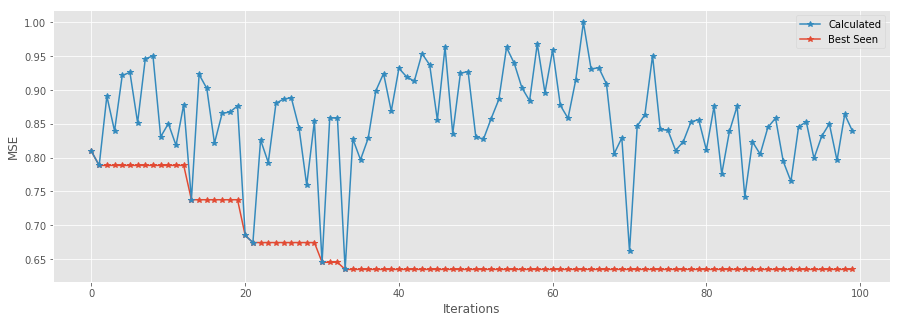

In [59]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

In [60]:
best_model_1.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 730, 1)]          0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 199)               159996    
_________________________________________________________________
dense_99 (Dense)             (None, 266)               53200     
_________________________________________________________________
dense_100 (Dense)            (None, 344)               91848     
_________________________________________________________________
dense_101 (Dense)            (None, 334)               115230    
Total params: 420,274
Trainable params: 420,274
Non-trainable params: 0
_________________________________________________________________


In [61]:
best_model_1.evaluate(X_train, y_train)
best_model_1.evaluate(X_val, y_val)

216/216 [==============================] - 2s 7ms/sample - loss: 0.6344 - mean_absolute_error: 0.5978


[0.6343823627189353, 0.59781843]

In [62]:
pred = best_model_1.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - valid)/np.abs(valid)))))

MAPE: 0.1592635173976809


### Second Architecture


In [22]:
#The number of epoch could also be an hyperparameter
# but to reduce the computation stress it has been 
# fixed to be 100, (on approximately 2000 data) it is sufficient,
# otherwise it will start overfitting a lot! 
def get_model_score(params, epochs=100, verbose=0):
    early = EarlyStopping(monitor='val_loss', patience=50, verbose=0)
    lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=0, 
                             factor=0.5, min_lr=1e-5)
    initial = Input(shape=(INPUT_SIZE,1))

    x = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)

    x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit2"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit3"]), activation='relu')(x)

    out = Dense(OUTPUT_SIZE, activation='linear')(x)

    model = Model(initial, out)

    model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[lr_decay, early],
            verbose=verbose)
    return model, model.evaluate(X_val, y_val)[0], hist


parameters = [sherpa.Discrete('lstm_unit',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Discrete('hidden_unit3',[256,512]),
              sherpa.Continuous('lr_init', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

best_score = 999999

for trial in study:
    start_time = time.time()
    
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
        score = 999999
        print("Model Crashed or 'NaNed'")
      
    if score != 999999:
        study.add_observation(trial, iteration=1, objective=score)
        if score < best_score:
            model.save(path + "best_model_2.h5")
            best_model   = model
            best_score   = score
            best_history = hist
    else:
        del model #free RAM
    study.finalize(trial)
    if(trial.id % 10 == 0 or trial.id == 1):
        print("Trial:",trial.id, "|| Best Score: ", best_score, " || Took ",str(time.time()-start_time), "Seconds")
    study.results.to_csv(path + "AutoML_2.csv")

216/216 [==============================] - 0s 441us/sample - loss: 0.9466 - mae: 0.7291
Trial: 1 || Best Score:  0.9465505017174615  || Took  49.651477336883545 Seconds
216/216 [==============================] - 0s 383us/sample - loss: 0.9320 - mae: 0.7148


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 596us/sample - loss: 0.7848 - mae: 0.6456


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 436us/sample - loss: 0.9554 - mae: 0.7413


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 413us/sample - loss: 0.9922 - mae: 0.7550


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 10 || Best Score:  0.6616520440136945  || Took  37.04777431488037 Seconds
216/216 [==============================] - 0s 600us/sample - loss: 0.8006 - mae: 0.6927


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 575us/sample - loss: 0.7162 - mae: 0.6430


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 520us/sample - loss: 0.8567 - mae: 0.6881


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 603us/sample - loss: 0.7895 - mae: 0.6934


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 590us/sample - loss: 0.7496 - mae: 0.6621


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 541us/sample - loss: 0.8122 - mae: 0.6879


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 568us/sample - loss: 0.7526 - mae: 0.6655


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 576us/sample - loss: 0.7635 - mae: 0.6656


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 572us/sample - loss: 0.7687 - mae: 0.6737


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 554us/sample - loss: 0.7329 - mae: 0.6562


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 20 || Best Score:  0.6616520440136945  || Took  103.38745379447937 Seconds
216/216 [==============================] - 0s 585us/sample - loss: 0.7171 - mae: 0.6438


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 590us/sample - loss: 0.7176 - mae: 0.6423


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 535us/sample - loss: 0.9841 - mae: 0.7344


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 605us/sample - loss: 0.7318 - mae: 0.6498


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 567us/sample - loss: 0.8836 - mae: 0.7042


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 535us/sample - loss: 0.7871 - mae: 0.6764


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 562us/sample - loss: 0.6608 - mae: 0.6098


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 559us/sample - loss: 0.7611 - mae: 0.6709


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 605us/sample - loss: 0.7254 - mae: 0.6463


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 611us/sample - loss: 0.8588 - mae: 0.7007


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 30 || Best Score:  0.6607614071280868  || Took  103.8719916343689 Seconds
216/216 [==============================] - 0s 596us/sample - loss: 0.8553 - mae: 0.7078


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 553us/sample - loss: 0.9552 - mae: 0.7429


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 569us/sample - loss: 0.9454 - mae: 0.7148


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 556us/sample - loss: 0.7918 - mae: 0.6840


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 482us/sample - loss: 0.9483 - mae: 0.7345


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 645us/sample - loss: 0.9821 - mae: 0.7435


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 509us/sample - loss: 0.9191 - mae: 0.7384


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 586us/sample - loss: 0.8331 - mae: 0.6965


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 586us/sample - loss: 0.8702 - mae: 0.7166


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 581us/sample - loss: 0.7346 - mae: 0.6420


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 40 || Best Score:  0.6607614071280868  || Took  102.65167093276978 Seconds
216/216 [==============================] - 0s 554us/sample - loss: 0.8275 - mae: 0.7014


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 663us/sample - loss: 0.9648 - mae: 0.7222


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 495us/sample - loss: 0.8623 - mae: 0.6804


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 381us/sample - loss: 0.9094 - mae: 0.7069


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 569us/sample - loss: 0.8231 - mae: 0.6937


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 453us/sample - loss: 1.0318 - mae: 0.7775


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 520us/sample - loss: 0.8053 - mae: 0.6579


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 571us/sample - loss: 0.8530 - mae: 0.6908


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 466us/sample - loss: 0.9121 - mae: 0.7052


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 445us/sample - loss: 0.9226 - mae: 0.7098


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 50 || Best Score:  0.6607614071280868  || Took  23.012603521347046 Seconds
216/216 [==============================] - 0s 451us/sample - loss: 0.9503 - mae: 0.7327


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 597us/sample - loss: 0.7850 - mae: 0.6762


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 512us/sample - loss: 0.8432 - mae: 0.7005


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 587us/sample - loss: 0.8247 - mae: 0.6978


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 605us/sample - loss: 0.8099 - mae: 0.6892


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 569us/sample - loss: 0.8975 - mae: 0.7364


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 590us/sample - loss: 0.9330 - mae: 0.7247


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 581us/sample - loss: 0.7546 - mae: 0.6589


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 579us/sample - loss: 0.9527 - mae: 0.7336


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 577us/sample - loss: 0.9241 - mae: 0.7097


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 60 || Best Score:  0.6607614071280868  || Took  48.22478413581848 Seconds
216/216 [==============================] - 0s 561us/sample - loss: 0.9592 - mae: 0.7213


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 602us/sample - loss: 0.7801 - mae: 0.6754


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 563us/sample - loss: 0.7517 - mae: 0.6640


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 548us/sample - loss: 0.8219 - mae: 0.6792


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 605us/sample - loss: 0.9505 - mae: 0.7222


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 577us/sample - loss: 0.7946 - mae: 0.6777


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 622us/sample - loss: 0.8747 - mae: 0.7106


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 582us/sample - loss: 0.9703 - mae: 0.7427


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 614us/sample - loss: 0.9611 - mae: 0.7441


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 505us/sample - loss: 0.9088 - mae: 0.7169


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 70 || Best Score:  0.6607614071280868  || Took  88.06490969657898 Seconds
216/216 [==============================] - 0s 587us/sample - loss: 0.8152 - mae: 0.6804


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 655us/sample - loss: 0.9194 - mae: 0.7163


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 532us/sample - loss: 0.9813 - mae: 0.7451


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 511us/sample - loss: 0.8346 - mae: 0.6794


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 504us/sample - loss: 0.9649 - mae: 0.7289


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 529us/sample - loss: 0.9395 - mae: 0.7149


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 457us/sample - loss: 0.9367 - mae: 0.7213


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 568us/sample - loss: 0.9247 - mae: 0.7197


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 538us/sample - loss: 0.8409 - mae: 0.6850


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 465us/sample - loss: 0.8183 - mae: 0.6821


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 80 || Best Score:  0.6607614071280868  || Took  62.66900086402893 Seconds
216/216 [==============================] - 0s 609us/sample - loss: 0.7989 - mae: 0.6816


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 601us/sample - loss: 0.9011 - mae: 0.7059


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 453us/sample - loss: 0.9433 - mae: 0.7151


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 561us/sample - loss: 0.8970 - mae: 0.7126


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 529us/sample - loss: 0.9621 - mae: 0.7259


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 572us/sample - loss: 0.9178 - mae: 0.7357


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 557us/sample - loss: 0.8786 - mae: 0.7009


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 506us/sample - loss: 0.9354 - mae: 0.7179


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 527us/sample - loss: 0.9838 - mae: 0.7313


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 550us/sample - loss: 1.0049 - mae: 0.7386


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 90 || Best Score:  0.6607614071280868  || Took  49.462482929229736 Seconds
216/216 [==============================] - 0s 623us/sample - loss: 0.8063 - mae: 0.6910


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 604us/sample - loss: 0.9819 - mae: 0.7241


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 492us/sample - loss: 0.8689 - mae: 0.7152


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 522us/sample - loss: 0.7645 - mae: 0.6730


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 571us/sample - loss: 0.9321 - mae: 0.7342


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 477us/sample - loss: 0.9332 - mae: 0.7350


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 589us/sample - loss: 0.9390 - mae: 0.7165


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 605us/sample - loss: 0.9102 - mae: 0.7186


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 528us/sample - loss: 0.8972 - mae: 0.7134


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 564us/sample - loss: 0.9147 - mae: 0.7083
Trial: 100 || Best Score:  0.6607614071280868  || Took  46.76960754394531 Seconds


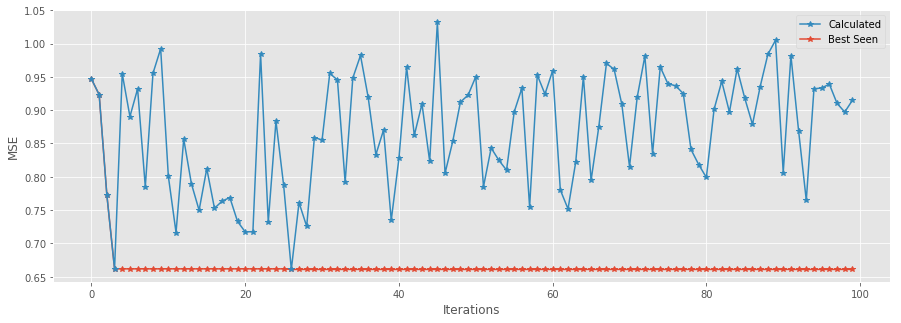

In [63]:
best_model_2 = tf.keras.models.load_model(path + "best_model_2.h5")
results = pd.read_csv(path + "AutoML_2.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()


In [64]:
best_model_2.summary()
best_model_2.evaluate(X_train, y_train)
best_model_2.evaluate(X_val, y_val)

Model: "model_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_127 (InputLayer)       [(None, 730, 1)]          0         
_________________________________________________________________
lstm_126 (LSTM)              (None, 201)               163212    
_________________________________________________________________
dense_404 (Dense)            (None, 468)               94536     
_________________________________________________________________
dense_405 (Dense)            (None, 459)               215271    
_________________________________________________________________
dense_406 (Dense)            (None, 465)               213900    
_________________________________________________________________
dense_407 (Dense)            (None, 334)               155644    
Total params: 842,563
Trainable params: 842,563
Non-trainable params: 0
___________________________________________________

[0.6607617404725816, 0.6097767]

In [65]:
pred = best_model_2.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - valid)/np.abs(valid)))))

MAPE: 0.15753438200925235


### Third Architecture

In [0]:
#The number of epoch could also be an hyperparameter
# but to reduce the computation stress it has been 
# fixed to be 100, (on approximately 2000 data) it is sufficient,
# otherwise it will start overfitting a lot! 
def get_model_score(params, epochs=100, verbose=0):
    early = EarlyStopping(monitor='val_loss', patience=50, verbose=0)
    lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=0, 
                             factor=0.5, min_lr=1e-5)
    initial = Input(shape=(INPUT_SIZE,1))

    x = LSTM(int(params['lstm_unit1']), activation='tanh', 
           return_sequences=True,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)
    x = LSTM(int(params['lstm_unit2']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(x)


    x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit2"]), activation='relu')(x)

    out = Dense(OUTPUT_SIZE, activation='linear')(x)

    model = Model(initial, out)

    model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[lr_decay, early],
            verbose=verbose)
    return model, model.evaluate(X_val, y_val)[0], hist


parameters = [sherpa.Discrete('lstm_unit1',[20,250]),
              sherpa.Discrete('lstm_unit2',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Continuous('lr_init', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

best_score = 999999

for trial in study:
    start_time = time.time()
    
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
        score = 999999
        print("Model Crashed or 'NaNed'")
      
    if score != 999999:
        study.add_observation(trial, iteration=1, objective=score)
        if score < best_score:
            model.save(path + "best_model_3.h5")
            best_model   = model
            best_score   = score
            best_history = hist
    else:
        del model #free RAM
    study.finalize(trial)
    if(trial.id % 10 == 0 or trial.id == 1):
        print("Trial:",trial.id, "|| Best Score: ", best_score, " || Took ",str(time.time()-start_time), "Seconds")
    study.results.to_csv(path + "AutoML_3.csv")

216/216 [==============================] - 0s 1ms/sample - loss: 0.9590 - mae: 0.7197
Trial: 1 || Best Score:  0.9589624007542928  || Took  149.93225407600403 Seconds
216/216 [==============================] - 0s 1ms/sample - loss: 1.0130 - mae: 0.7522


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9302 - mae: 0.7224


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7033 - mae: 0.6136


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9467 - mae: 0.7190


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 10 || Best Score:  0.7033185693952773  || Took  152.0399763584137 Seconds
216/216 [==============================] - 0s 900us/sample - loss: 0.9560 - mae: 0.7288


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9147 - mae: 0.6963


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9048 - mae: 0.6893


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7571 - mae: 0.6612


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9755 - mae: 0.7362


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 895us/sample - loss: 0.9285 - mae: 0.6958


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 827us/sample - loss: 0.9180 - mae: 0.6968


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7402 - mae: 0.6601


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 886us/sample - loss: 0.9753 - mae: 0.7360


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9126 - mae: 0.6934


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 20 || Best Score:  0.7033185693952773  || Took  128.42612624168396 Seconds
216/216 [==============================] - 0s 1ms/sample - loss: 0.9224 - mae: 0.6876


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 906us/sample - loss: 0.9599 - mae: 0.7211


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7820 - mae: 0.6379


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 964us/sample - loss: 1.0324 - mae: 0.7629


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 922us/sample - loss: 0.7030 - mae: 0.6138


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9538 - mae: 0.7177


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 976us/sample - loss: 0.9724 - mae: 0.7362


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9588 - mae: 0.7418


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 899us/sample - loss: 0.9325 - mae: 0.7098


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 819us/sample - loss: 0.8558 - mae: 0.6744


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 30 || Best Score:  0.7030123317683185  || Took  61.07102012634277 Seconds
216/216 [==============================] - 0s 938us/sample - loss: 0.9459 - mae: 0.7114


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 834us/sample - loss: 0.8872 - mae: 0.6822


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8249 - mae: 0.6950


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9762 - mae: 0.7414


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 904us/sample - loss: 0.9042 - mae: 0.6856


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 960us/sample - loss: 0.9068 - mae: 0.6960


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 958us/sample - loss: 0.9574 - mae: 0.7160


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 983us/sample - loss: 0.8926 - mae: 0.6807


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 855us/sample - loss: 0.9234 - mae: 0.7040


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8966 - mae: 0.6833


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 40 || Best Score:  0.7030123317683185  || Took  203.91958594322205 Seconds
216/216 [==============================] - 0s 1ms/sample - loss: 0.9594 - mae: 0.7353


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8005 - mae: 0.6732


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 987us/sample - loss: 0.7495 - mae: 0.6523


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8677 - mae: 0.6795


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 938us/sample - loss: 0.9746 - mae: 0.7396


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 912us/sample - loss: 0.9396 - mae: 0.7102


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8202 - mae: 0.6986


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 855us/sample - loss: 0.9865 - mae: 0.7465


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9206 - mae: 0.6956


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9470 - mae: 0.7147


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 50 || Best Score:  0.7030123317683185  || Took  134.02725219726562 Seconds
216/216 [==============================] - 0s 1ms/sample - loss: 0.7037 - mae: 0.6138


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 972us/sample - loss: 0.9451 - mae: 0.7178


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7677 - mae: 0.6598


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 1.0637 - mae: 0.7654


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 843us/sample - loss: 0.7030 - mae: 0.6138


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 912us/sample - loss: 0.9501 - mae: 0.7214


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8807 - mae: 0.6729


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8870 - mae: 0.6761


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7041 - mae: 0.6138


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 886us/sample - loss: 0.9721 - mae: 0.7451


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 60 || Best Score:  0.7029806066442419  || Took  148.07533359527588 Seconds
216/216 [==============================] - 0s 973us/sample - loss: 0.9148 - mae: 0.6955


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 939us/sample - loss: 0.9835 - mae: 0.7345


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 908us/sample - loss: 0.9360 - mae: 0.7294


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7038 - mae: 0.6138


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 906us/sample - loss: 0.9759 - mae: 0.7358


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7044 - mae: 0.6136


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 1.0106 - mae: 0.7757


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1000us/sample - loss: 0.9107 - mae: 0.7060


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 997us/sample - loss: 1.0449 - mae: 0.6839


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8849 - mae: 0.6848


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 70 || Best Score:  0.7029806066442419  || Took  167.2893843650818 Seconds
216/216 [==============================] - 0s 1ms/sample - loss: 0.8154 - mae: 0.6937


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9104 - mae: 0.7209


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 977us/sample - loss: 0.7032 - mae: 0.6139


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9108 - mae: 0.6909


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.9629 - mae: 0.7321


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.8975 - mae: 0.7219


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 854us/sample - loss: 0.9810 - mae: 0.7444


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 968us/sample - loss: 0.9934 - mae: 0.7494


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7868 - mae: 0.6815


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 954us/sample - loss: 0.9395 - mae: 0.7162
Trial: 80 || Best Score:  0.7029806066442419  || Took  129.60137104988098 Seconds


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 980us/sample - loss: 0.9233 - mae: 0.6977


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 870us/sample - loss: 0.9743 - mae: 0.7390


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 893us/sample - loss: 0.9295 - mae: 0.7058


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 964us/sample - loss: 0.9034 - mae: 0.6810


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 968us/sample - loss: 0.9819 - mae: 0.7380


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 944us/sample - loss: 3.0617 - mae: 1.3459


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 908us/sample - loss: 0.9522 - mae: 0.7230


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7040 - mae: 0.6139


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 816us/sample - loss: 0.9337 - mae: 0.7110


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


216/216 [==============================] - 0s 1ms/sample - loss: 0.7033 - mae: 0.6137


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 90 || Best Score:  0.7029806066442419  || Took  273.11340594291687 Seconds
216/216 [==============================] - 0s 1ms/sample - loss: 0.7035 - mae: 0.6137


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


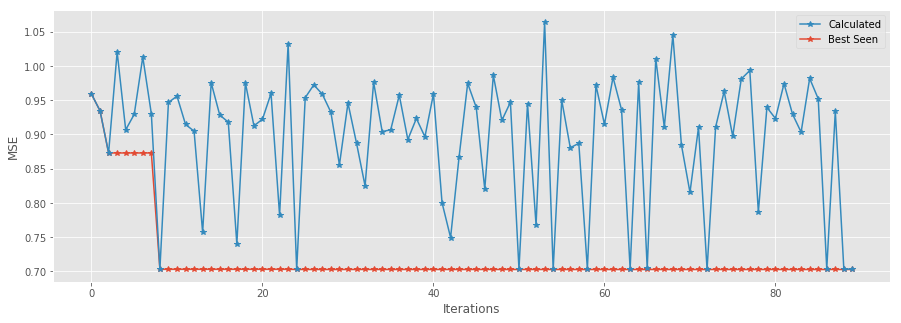

In [66]:
best_model_3 = tf.keras.models.load_model(path + "best_model_3.h5")
results = pd.read_csv(path + "AutoML_3.csv")
results = results[results["Status"]=="COMPLETED"]
results = results[results["Objective"] < 2]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()


In [67]:
best_model_3.summary()
best_model_3.evaluate(X_train, y_train)
best_model_3.evaluate(X_val, y_val)

Model: "model_254"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_255 (InputLayer)       [(None, 730, 1)]          0         
_________________________________________________________________
lstm_308 (LSTM)              (None, 730, 102)          42432     
_________________________________________________________________
lstm_309 (LSTM)              (None, 93)                72912     
_________________________________________________________________
dense_862 (Dense)            (None, 464)               43616     
_________________________________________________________________
dense_863 (Dense)            (None, 272)               126480    
_________________________________________________________________
dense_864 (Dense)            (None, 334)               91182     
Total params: 376,622
Trainable params: 376,622
Non-trainable params: 0
___________________________________________________

[0.7029806287200363, 0.6137937]

In [68]:
pred = best_model_3.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - valid)/np.abs(valid)))))

MAPE: 0.15885059626617093


**Best model is the second one**

In [117]:
### Best performance is the second one:

best_model = best_model_2

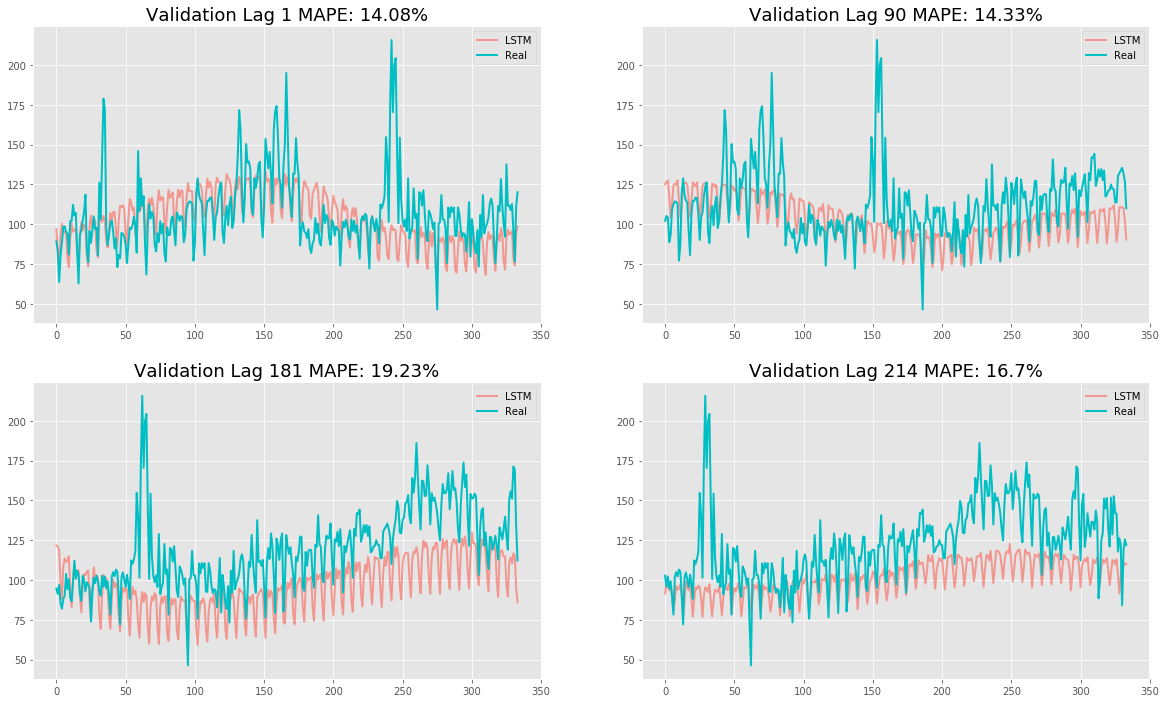

In [119]:
plt.figure(figsize=(20,12))
i = 1

X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(-1,1)
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(-1,)
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,1)
pred_, = plt.plot(pred_i, color="#F8766D",linewidth=2,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4",linewidth=2)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)

i = 90
X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(-1,1)
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(-1,)
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,2)
pred_, = plt.plot(pred_i, color="#F8766D", linewidth=2,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4", linewidth=2)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)


i = 181
X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(-1,1)
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(-1,)
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,3)
pred_, = plt.plot(pred_i, color="#F8766D",linewidth=2,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4",linewidth=2)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)


i = 214
X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(-1,1)
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(-1,)
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,4)
pred_, = plt.plot(pred_i, color="#F8766D",linewidth=2,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4",linewidth=2)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)
plt.savefig("imgs/forecast_lstm.png", bbox_inches='tight', pad_inches=0)
plt.show()

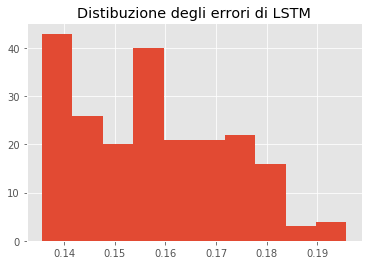

In [71]:
pred = best_model.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

plt.hist(list(map(np.mean,np.abs(pred - valid)/np.abs(valid))))
plt.title("Distibuzione degli errori di LSTM")
plt.show()

In [72]:
#Training performance for the best model
pred = best_model.predict(X_train)
y_train_ = x_scaler.inverse_transform(y_train).reshape(y_train.shape[0],y_train.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - y_train_)/np.abs(y_train_)))))

MAPE: 0.1365339861384095


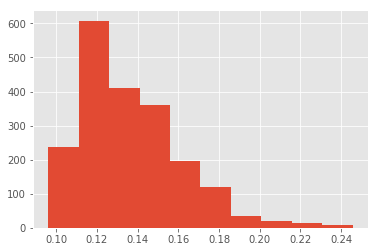

In [73]:
plt.hist(list(map(np.mean,np.abs(pred - y_train_)/np.abs(y_train_))))
plt.show()

# Conclusion with final predictions

### ARIMA

In [29]:
%%time
%%R -w 800 -h 400

                                     
#create dummy

freq <- outer(1:(length(idata)+365), 1:24)*2*pi/365.25 

cs   <- cos(freq)                   
colnames(cs) <- paste("cos", 1:24)
si   <- sin(freq)                   
colnames(si) <- paste("cos", 1:24)

more_reg <- as.matrix(cbind(cs,si))


xreg <- more_reg 

mod_final_reg <- Arima(idata, c(6,1,6), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:length(idata),], include.constant = TRUE, lambda = "auto")


Error in is.ts(x) : object 'mod1_reg' not found
CPU times: user 25min 11s, sys: 42min 44s, total: 1h 7min 55s
Wall time: 8min 38s


/home/pranav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in is.ts(x) : object 'mod1_reg' not found

  warnings.warn(x, RRuntimeWarning)


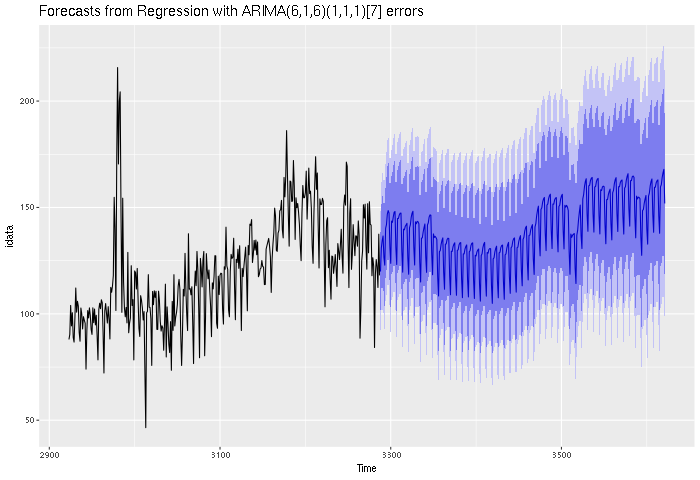

In [31]:
%%R -w 700
arima_test <- forecast(mod_final_reg, h=334, xreg=xreg[(length(idata)+1):(length(idata)+334),])
arima_test_mean <- arima_test$mean

autoplot(arima_test, include=365)

### UCM

In [25]:
%%time
%%R
extra <- data.frame(Data=seq(as.Date("2019-01-01"), as.Date("2019-11-30"), by="day"), value=NA)
new_df <- rbind(df,extra)
ytrain <- xts(new_df$value, order.by=new_df$Data)

ucm_mod_final <- SSModel(ytrain ~ SSMtrend(2, list(0,NA)) +
                          SSMseasonal(7, NA, "dummy") +
                          SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                         H = NA)

vary <- var(ytrain, na.rm = TRUE)
ucm_mod_final$P1inf <- ucm_mod_final$P1inf * 0
ucm_mod_final$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod_final$P1) <- vary



#valore iniziale delle varianze
init <- numeric(5)
init[1] <- 0 
init[2] <- log(vary/10)
init[3] <- log(vary/100)
init[4] <- log(vary/100)
init[5] <- log(vary/10)

# Estimate
update_fun <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[4:51, 4:51, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit_final <- fitSSM(ucm_mod_final, init, update_fun)
print(fit_final$optim.out$convergence)

[1] 0


CPU times: user 2min 8s, sys: 2min 57s, total: 5min 6s
Wall time: 45.1 s


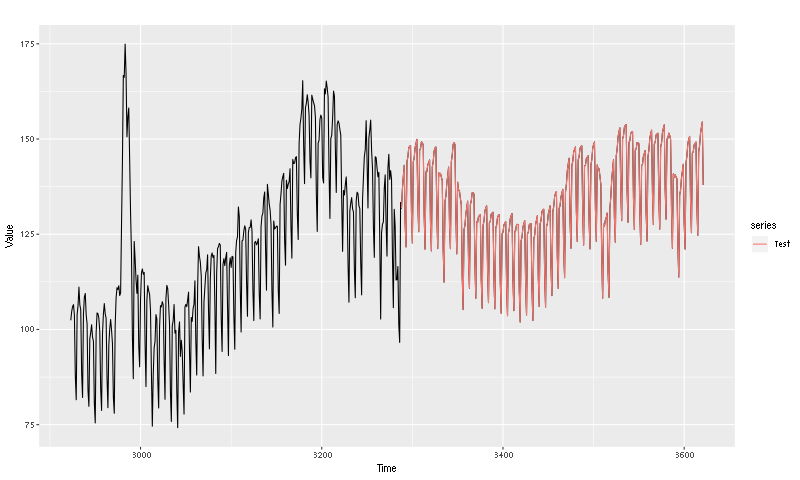

In [26]:
%%R -w 800
smo_final <- KFS(fit_final$model, filtering="mean",smoothing="none")
ucm_test_mean <- smo_final$m[(length(ytrain)-334+1):length(ytrain)]


plot_ucm <- xts(as.numeric(smo_final$m), order.by=new_df$Data)
autoplot(xts_to_ts(plot_ucm["2018-01-01/2019-11-30"]))+
    autolayer(xts_to_ts(plot_ucm["2019-01-01/2019-11-30"]), series="Test") +
    ylab("Value")

### LSTM

In [78]:
best_model = tf.keras.models.load_model(path + "best_model_2.h5")
best_model.fit(X_val,y_val,epochs=100, verbose=1)

Train on 216 samples
Epoch 1/100
216/216 [==============================] - 5s 22ms/sample - loss: 0.6127 - mean_absolute_error: 0.5710
Epoch 2/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.5758 - mean_absolute_error: 0.5454
Epoch 3/100
216/216 [==============================] - 4s 20ms/sample - loss: 0.5587 - mean_absolute_error: 0.5333
Epoch 4/100
216/216 [==============================] - 4s 20ms/sample - loss: 0.5454 - mean_absolute_error: 0.5261
Epoch 5/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.5339 - mean_absolute_error: 0.5152
Epoch 6/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.5226 - mean_absolute_error: 0.5087
Epoch 7/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.5128 - mean_absolute_error: 0.5031
Epoch 8/100
216/216 [==============================] - 4s 20ms/sample - loss: 0.5025 - mean_absolute_error: 0.4966
Epoch 9/100
216/216 [==============================] - 4s 2

216/216 [==============================] - 4s 20ms/sample - loss: 0.3547 - mean_absolute_error: 0.3939
Epoch 72/100
216/216 [==============================] - 4s 20ms/sample - loss: 0.3545 - mean_absolute_error: 0.3937
Epoch 73/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.3539 - mean_absolute_error: 0.3933
Epoch 74/100
216/216 [==============================] - 4s 20ms/sample - loss: 0.3537 - mean_absolute_error: 0.3933
Epoch 75/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.3532 - mean_absolute_error: 0.3928
Epoch 76/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.3523 - mean_absolute_error: 0.3920
Epoch 77/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.3519 - mean_absolute_error: 0.3916
Epoch 78/100
216/216 [==============================] - 4s 19ms/sample - loss: 0.3514 - mean_absolute_error: 0.3911
Epoch 79/100
216/216 [==============================] - 4s 20ms/sample - loss: 0.3514

In [79]:
%%R
test <- idata["2017-01-01/"] #dati dal 2017 in poi

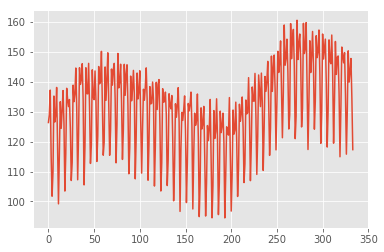

In [80]:
%R -o test
X_test = x_scaler.transform(np.array(test)).reshape(1,-1,1)
lstm_test = x_scaler.inverse_transform(best_model.predict(X_test)[0])

plt.plot(lstm_test)
plt.show()

### All toghether

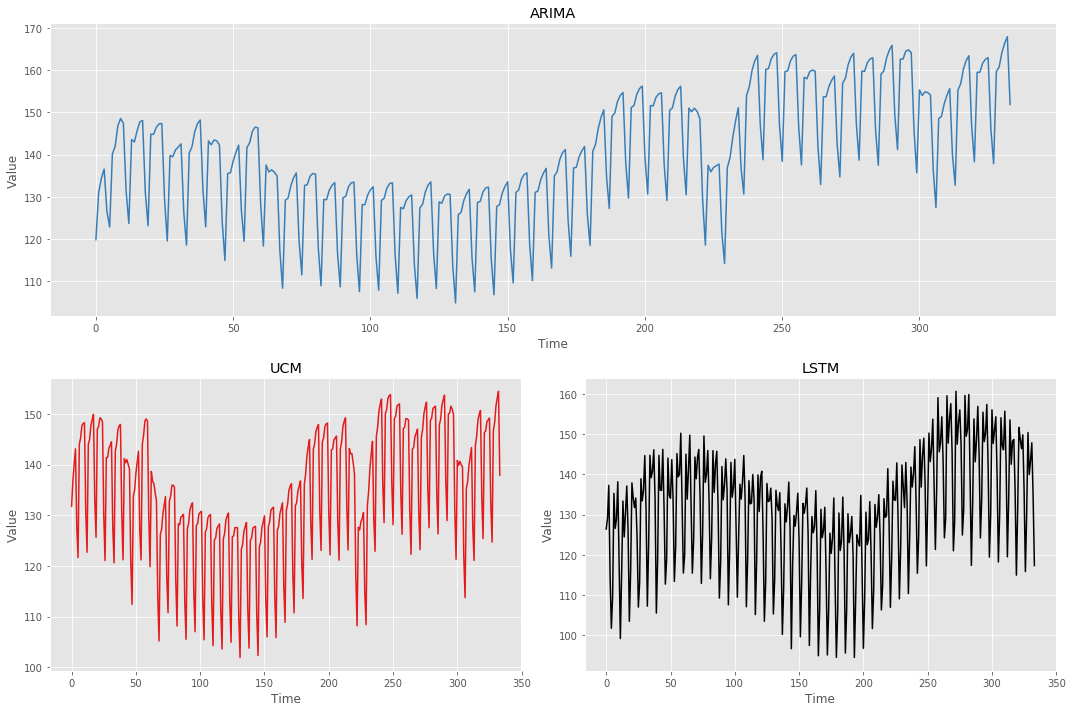

In [81]:
%R -o ucm_test_mean -o arima_test_mean


# plot it
fig = plt.figure(figsize=(15, 10))

ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)

plt.plot(np.array(arima_test_mean), color="#377eb8")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("ARIMA")

ax1 = plt.subplot2grid((2, 2), (1, 0))

plt.plot(np.array(ucm_test_mean), color="#e41a1c")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("UCM")

ax2 = plt.subplot2grid((2, 2), (1, 1))

plt.plot(np.array(lstm_test), color="black")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("LSTM")

plt.tight_layout()
plt.savefig('imgs/test_results.png')

In [82]:
submission = pd.DataFrame({'Data':pd.date_range('2019-01-01', periods=334, freq='D'),
                          'ARIMA':arima_test_mean,
                          'UCM':ucm_test_mean,
                          'ML':lstm_test})

In [83]:
submission

,Data,ARIMA,UCM,ML
0,2019-01-01,119.882134,131.785011,126.406441
1,2019-01-02,131.020105,136.794452,129.063446
2,2019-01-03,134.440564,140.131911,137.243164
3,2019-01-04,136.587609,143.084143,115.061623
4,2019-01-05,126.606779,127.965265,101.765137
...,...,...,...,...
329,2019-11-26,160.720609,148.284387,139.931549
330,2019-11-27,164.093695,151.532807,143.394836
331,2019-11-28,166.332664,153.124608,147.817093
332,2019-11-29,167.904659,154.459460,134.596741


In [84]:
submission.to_csv(path + 'SDMTSA_846965_1.csv', index=None)

# Trying LSTM on ARIMA for the training set

In [90]:
%%R
residuals <- as.numeric(mod_final_reg$residual)

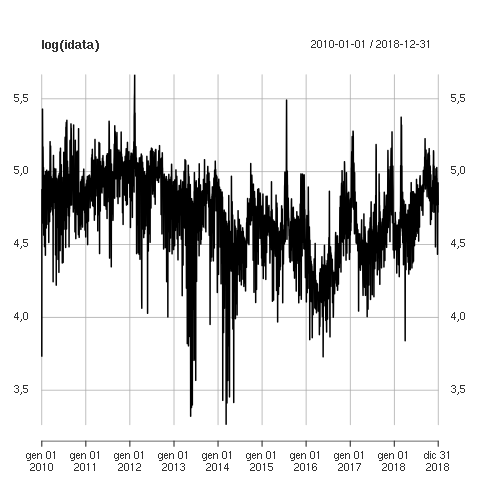

In [96]:
%%R
plot(log(idata), type="l")

In [126]:
%R -o residuals

In [127]:
INPUT_SIZE = 365*2 #2 years
OUTPUT_SIZE = 334

In [121]:
X,y = sliding_windows(residuals, INPUT_SIZE, OUTPUT_SIZE)

In [122]:
X.shape

(1673, 730)

In [74]:
X_train = X[:1500]
X_val = X[1500:]

y_train = y[:1500]
y_val = y[1500:]

In [75]:
x_scaler = StandardScaler().fit(X_train)

X_train = x_scaler.transform(X_train)
X_val = x_scaler.transform(X_val)



y_scaler = StandardScaler().fit(y_train)

y_train =  y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)

In [76]:
X_train = X_train.reshape(-1,INPUT_SIZE,1)
X_val = X_val.reshape(-1,INPUT_SIZE,1)

In [77]:
early = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                         patience=3, verbose=0, 
                         factor=0.5, min_lr=1e-5)

initial = Input(shape=(INPUT_SIZE,1))

x = LSTM(201, activation='tanh', 
       return_sequences=False,
       kernel_regularizer=regularizers.l1(0.01),
       activity_regularizer=regularizers.l1(0.01))(initial)

x = Dense(465, activation='relu')(x)

out = Dense(OUTPUT_SIZE, activation='linear')(x)

model = Model(initial, out)

model.compile(loss='mse',
            optimizer=optimizers.RMSprop(learning_rate=0.005), 
            metrics=['mae'])

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
        batch_size=128, epochs=10, 
        callbacks=[lr_decay, early],
        verbose=1)

Train on 1500 samples, validate on 173 samples
Epoch 1/10
1500/1500 [==============================] - 19s 13ms/sample - loss: 1.1220 - mae: 0.7157 - val_loss: 0.7451 - val_mae: 0.6208
Epoch 2/10
1500/1500 [==============================] - 17s 11ms/sample - loss: 1.0277 - mae: 0.7153 - val_loss: 0.7409 - val_mae: 0.6208
Epoch 3/10
1500/1500 [==============================] - 17s 11ms/sample - loss: 1.0252 - mae: 0.7153 - val_loss: 0.7394 - val_mae: 0.6208
Epoch 4/10
1500/1500 [==============================] - 17s 11ms/sample - loss: 1.0241 - mae: 0.7153 - val_loss: 0.7382 - val_mae: 0.6208
Epoch 5/10
1500/1500 [==============================] - 17s 11ms/sample - loss: 1.0237 - mae: 0.7153 - val_loss: 0.7378 - val_mae: 0.6209
Epoch 6/10
1500/1500 [==============================] - 17s 11ms/sample - loss: 1.0232 - mae: 0.7153 - val_loss: 0.7377 - val_mae: 0.6208
Epoch 7/10
1500/1500 [==============================] - 17s 11ms/sample - loss: 1.0231 - mae: 0.7153 - val_loss: 0.7381 - val

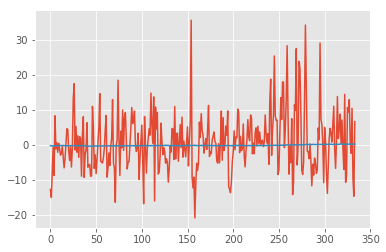

In [78]:
plt.plot(y_scaler.inverse_transform(y_val[0]))
plt.plot(y_scaler.inverse_transform(model.predict(X_val)[0]))
plt.show()